# Load Libraries

In [1]:
import numpy as np
import pandas as pd
import glob,os
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from boruta import BorutaPy
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import silhouette_visualizer
from collections import defaultdict
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import chi2 # chi-squared test
from sklearn.feature_selection import SelectKBest
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

C:\Users\jiekl\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Import Data

In [2]:
df = pd.read_csv("Insurance_Data.csv", thousands=',') 
df.columns = df.columns.str.upper()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AGE                    408 non-null    float64
 1   GENDER                 500 non-null    object 
 2   MARITALSTATUS          358 non-null    object 
 3   SMOKERSTATUS           434 non-null    object 
 4   LIFESTYLE              500 non-null    object 
 5   LANGUAGESPOKEN         500 non-null    object 
 6   HIGHESTEDUCATION       500 non-null    object 
 7   RACE                   385 non-null    object 
 8   NATIONALITY            355 non-null    object 
 9   MALAYSIAPR             500 non-null    object 
 10  MOVINGTONEWCOMPANY     500 non-null    object 
 11  OCCUPATION             355 non-null    object 
 12  TELCO                  500 non-null    object 
 13  HOMEADDRESS            421 non-null    object 
 14  RESIDENTIALTYPE        500 non-null    object 
 15  NOOFDE

## 1.0 Exploratory Data Analysis and Data Pre-Processing

### 1.1 Exploratary Data Analysis

#### 1.1.1 Target Data

,PURCHASEDPLAN1,COUNT
0,SchoolAgain,294
1,COVIDFree,110
2,HomeSafe,96


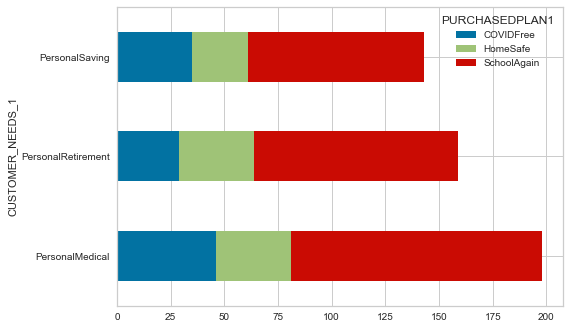

In [4]:
#Distribution of cases by customer_need & purchasedplan 
table = pd.crosstab(df['CUSTOMER_NEEDS_1'], df['PURCHASEDPLAN1'])
table.plot(kind='barh', stacked=True)
pd.DataFrame(df['PURCHASEDPLAN1'].value_counts()).reset_index().rename(columns={'PURCHASEDPLAN1': 'COUNT','index':'PURCHASEDPLAN1'})

,PURCHASEDPLAN2,COUNT
0,XEdu,189
1,KidsFlyUp,157
2,NoMoneyDown,154


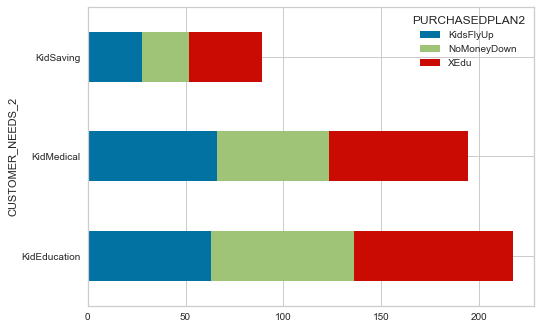

In [5]:
table = pd.crosstab(df['CUSTOMER_NEEDS_2'], df['PURCHASEDPLAN2'])
table.plot(kind='barh', stacked=True)
pd.DataFrame(df['PURCHASEDPLAN2'].value_counts()).reset_index().rename(columns={'PURCHASEDPLAN2': 'COUNT','index':'PURCHASEDPLAN2'})

#### 1.1.2 Bar Plot

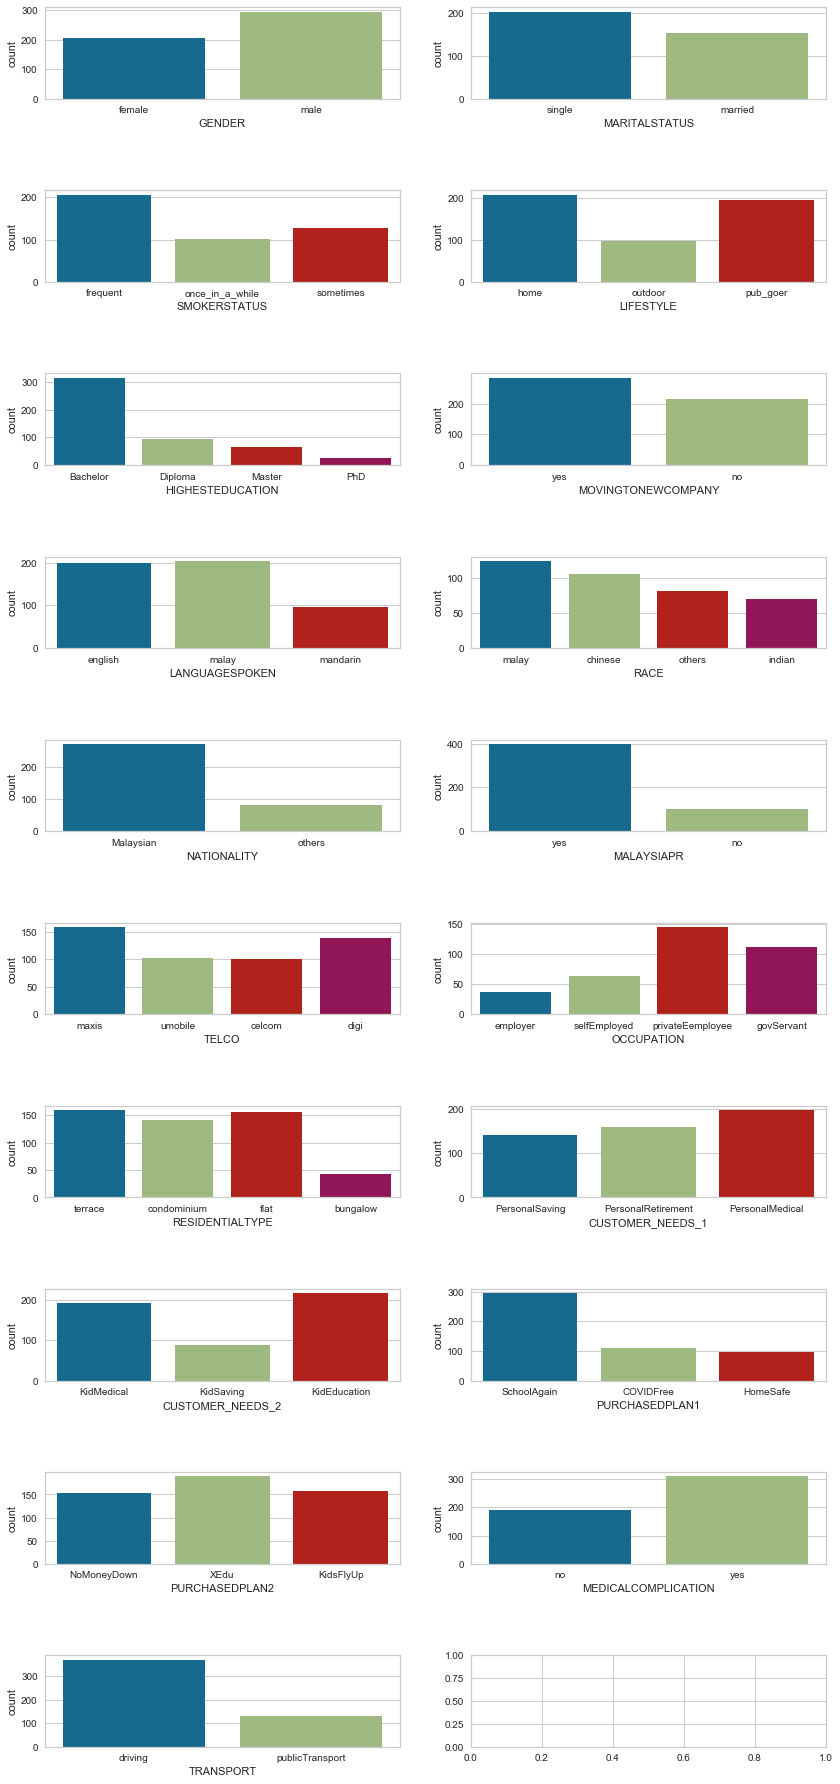

In [6]:
categorical_columns = df[['GENDER', 'MARITALSTATUS', 'SMOKERSTATUS', 
                       'LIFESTYLE', 'HIGHESTEDUCATION', 'MOVINGTONEWCOMPANY',
                        'LANGUAGESPOKEN','RACE', "NATIONALITY","MALAYSIAPR","TELCO",
                       'OCCUPATION','RESIDENTIALTYPE','CUSTOMER_NEEDS_1','CUSTOMER_NEEDS_2','PURCHASEDPLAN1','PURCHASEDPLAN2',
                        "MEDICALCOMPLICATION","TRANSPORT",]]
numeric_columns = df[["AGE","NOOFDEPENDENT","FAMILYEXPENSES(MONTH)","ANNUALSALARY"]]
fig,axes = plt.subplots(10,2,figsize=(14,32))
for idx,cat_col in enumerate(categorical_columns):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=df,ax=axes[row,col])
plt.subplots_adjust(hspace=1)

#### 1.1.3 Crosstab

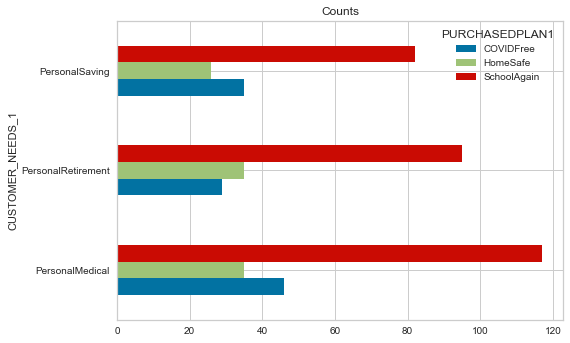

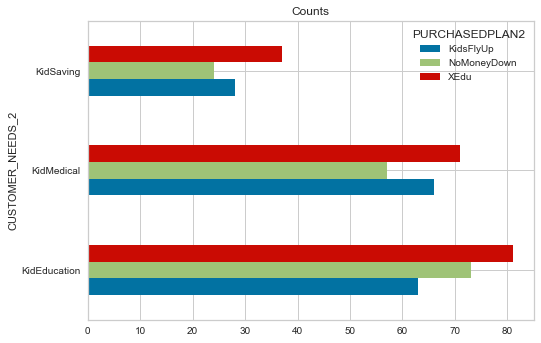

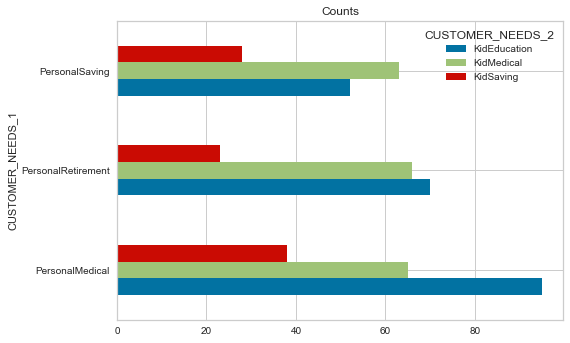

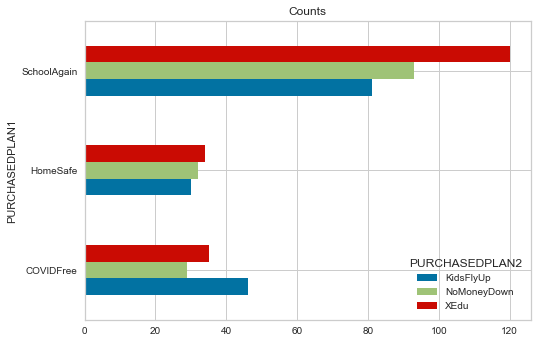

In [7]:
table=pd.crosstab(df['CUSTOMER_NEEDS_1'], df['PURCHASEDPLAN1'])
table.plot(kind='barh', title='Counts')
plt.show()
table=pd.crosstab(df['CUSTOMER_NEEDS_2'], df['PURCHASEDPLAN2'])
table.plot(kind='barh', title='Counts')
plt.show()
table=pd.crosstab(df['CUSTOMER_NEEDS_1'], df['CUSTOMER_NEEDS_2'])
table.plot(kind='barh', title='Counts')
plt.show()
table=pd.crosstab(df['PURCHASEDPLAN1'], df['PURCHASEDPLAN2'])
table.plot(kind='barh', title='Counts')
plt.show()

#### 1.1.4 Barh plot with customer purchasedplan

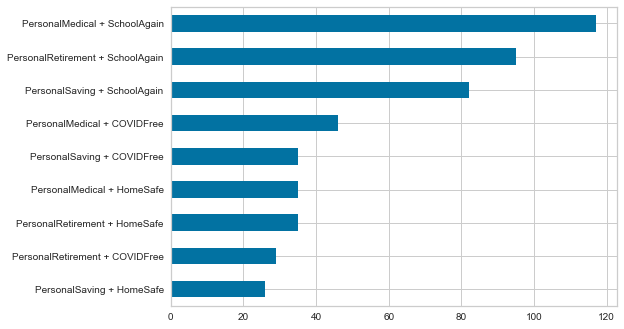

In [8]:
df['CUSTOMER_PURCHASED1'] = df[['CUSTOMER_NEEDS_1', 'PURCHASEDPLAN1']].agg(' + '.join, axis=1)
df['CUSTOMER_PURCHASED1'].value_counts().sort_values(ascending=True).plot(kind="barh")

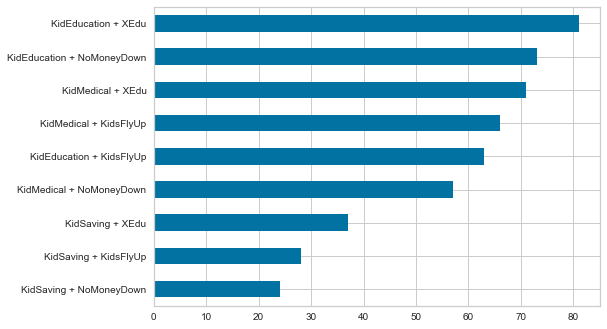

In [9]:
df['CUSTOMER_PURCHASED2'] = df[['CUSTOMER_NEEDS_2', 'PURCHASEDPLAN2']].agg(' + '.join, axis=1)
df['CUSTOMER_PURCHASED2'].value_counts().sort_values(ascending=True).plot(kind="barh")

####  1.1.5 Box plot

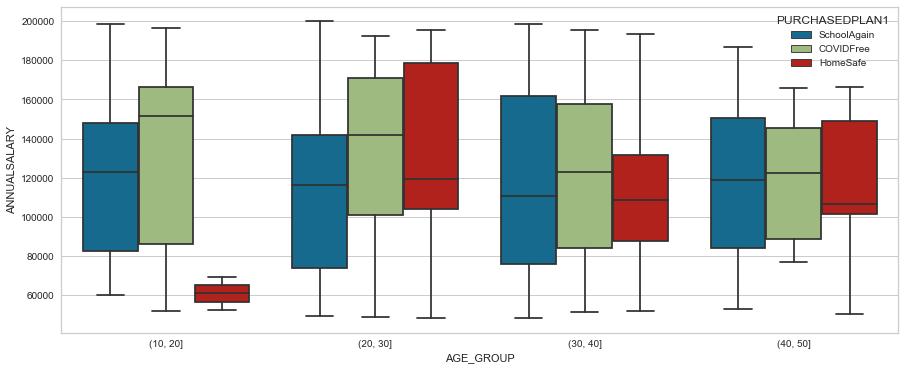

In [10]:
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=[10,20,30,40,50])

fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=df, x="AGE_GROUP", y="ANNUALSALARY", hue="PURCHASEDPLAN1", ax=ax)

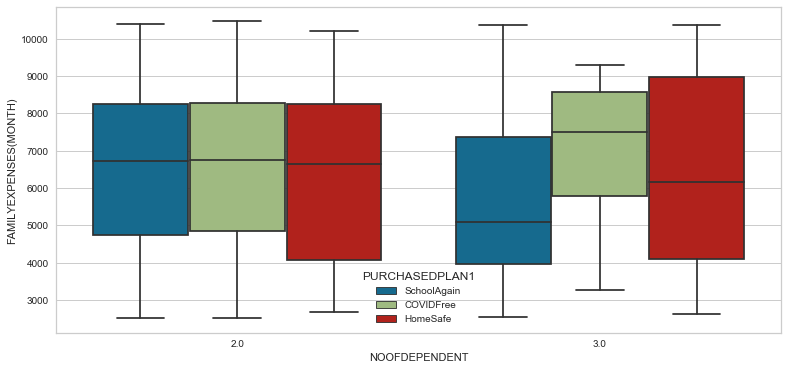

In [11]:
fig, ax = plt.subplots(figsize=(13, 6))
ax = sns.boxplot(x="NOOFDEPENDENT", y="FAMILYEXPENSES(MONTH)", hue="PURCHASEDPLAN1",
                     data=df)

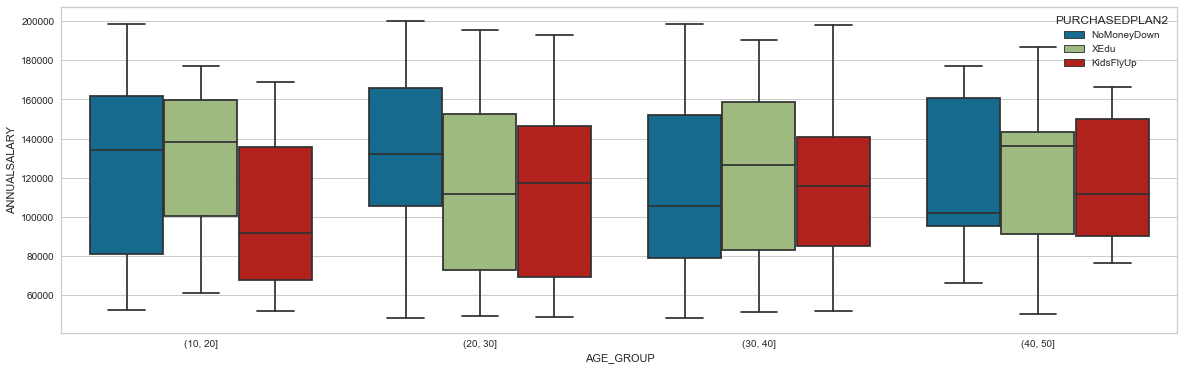

In [12]:
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=[10,20,30,40,50])

fig, ax = plt.subplots(figsize=(20, 6))
sns.boxplot(data=df, x="AGE_GROUP", y="ANNUALSALARY", hue="PURCHASEDPLAN2", ax=ax)

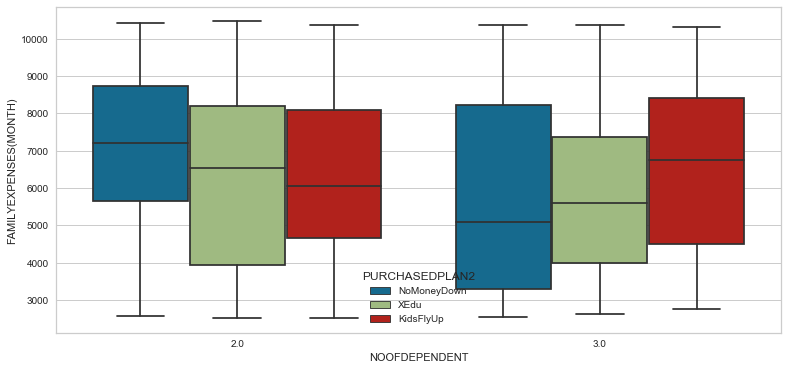

In [13]:
fig, ax = plt.subplots(figsize=(13, 6))
ax = sns.boxplot(x="NOOFDEPENDENT", y="FAMILYEXPENSES(MONTH)", hue="PURCHASEDPLAN2",
                     data=df)

Text(0.5, 1.0, 'PURCHASEDPLAN2 vs FAMILYEXPENSES(MONTH)')

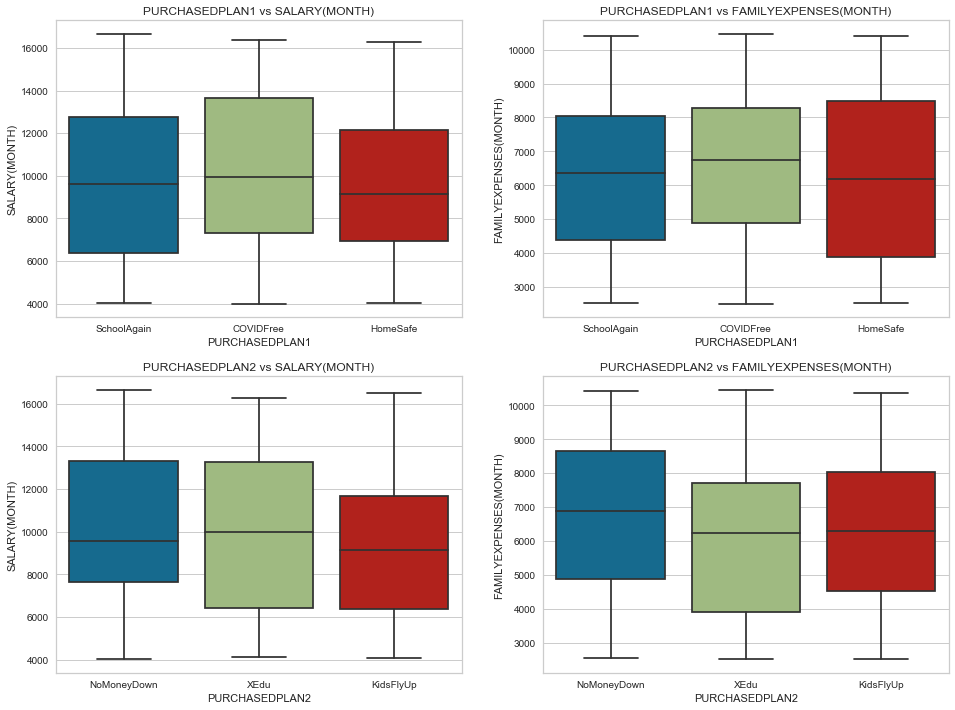

In [14]:
df['SALARY(MONTH)'] = df['ANNUALSALARY']/12

fig, axes = plt.subplots(2,2, figsize=(16,12))
a = sns.boxplot(x='PURCHASEDPLAN1', y='SALARY(MONTH)', data=df, ax=axes[0][0])
a.set_title('PURCHASEDPLAN1 vs SALARY(MONTH)')
b = sns.boxplot(x='PURCHASEDPLAN1', y='FAMILYEXPENSES(MONTH)', data=df, ax=axes[0][1])
b.set_title('PURCHASEDPLAN1 vs FAMILYEXPENSES(MONTH)')
c = sns.boxplot(x='PURCHASEDPLAN2', y='SALARY(MONTH)', data=df, ax=axes[1][0])
c.set_title('PURCHASEDPLAN2 vs SALARY(MONTH)')
d = sns.boxplot(x='PURCHASEDPLAN2', y='FAMILYEXPENSES(MONTH)', data=df, ax=axes[1][1])
d.set_title('PURCHASEDPLAN2 vs FAMILYEXPENSES(MONTH)')

### 1.2 Pre-processing

In [15]:
df2 = df.copy()
df2.drop(["CUSTOMER_PURCHASED2","CUSTOMER_PURCHASED1"],1,inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   AGE                    408 non-null    float64 
 1   GENDER                 500 non-null    object  
 2   MARITALSTATUS          358 non-null    object  
 3   SMOKERSTATUS           434 non-null    object  
 4   LIFESTYLE              500 non-null    object  
 5   LANGUAGESPOKEN         500 non-null    object  
 6   HIGHESTEDUCATION       500 non-null    object  
 7   RACE                   385 non-null    object  
 8   NATIONALITY            355 non-null    object  
 9   MALAYSIAPR             500 non-null    object  
 10  MOVINGTONEWCOMPANY     500 non-null    object  
 11  OCCUPATION             355 non-null    object  
 12  TELCO                  500 non-null    object  
 13  HOMEADDRESS            421 non-null    object  
 14  RESIDENTIALTYPE        500 non-null    obj

#### 1.2.1 Filling NaN Values

In [16]:
df2["AGE"] = df2['AGE'].fillna(round(df2["AGE"].mean(),0))
df2['NOOFDEPENDENT'] = df2['NOOFDEPENDENT'].fillna(round(df2["NOOFDEPENDENT"].mean(),0))
df2["FAMILYEXPENSES(MONTH)"] = df2["FAMILYEXPENSES(MONTH)"].fillna(df2.groupby("RESIDENTIALTYPE")['FAMILYEXPENSES(MONTH)'].transform('mean'))
df2["ANNUALSALARY"] = df2["ANNUALSALARY"].fillna(df2.groupby("RESIDENTIALTYPE")['ANNUALSALARY'].transform('mean'))
df2["SALARY(MONTH)"] = df2["SALARY(MONTH)"].fillna(df2.groupby("RESIDENTIALTYPE")['SALARY(MONTH)'].transform('mean'))

categorical_columns_mask = df2.dtypes==object
categorical_columns = df2.columns[categorical_columns_mask].tolist()
categorical_columns

for col_name in categorical_columns:
    df2[col_name].fillna('NotSpecified', inplace=True)

#Do not fill the categorical at the end, due to we cannot cimply fill it and it will reduce the accuracy as well
#df2['MARITALSTATUS'].value_counts()
#0.43 S, 0.57 m
#df2['MARITALSTATUS'] = df2['MARITALSTATUS'].fillna(pd.Series(np.random.choice(['single','married'], 
                                                      #p=[0.43,0.57], size=len(df))))
#df2['SMOKERSTATUS'].value_counts()
#0.48 f, 0.29 s, 0.23 o
#df2['SMOKERSTATUS'] = df2['SMOKERSTATUS'].fillna(pd.Series(np.random.choice(['frequent','sometimes','once_in_a_while'], 
                                                      #p=[0.48,0.29,0.23], size=len(df2))))
#df2['OCCUPATION'].value_counts()
#0.41 pe, 0.31 gs, 0.18 se, 0.10 e
#df2['OCCUPATION'] = df2['OCCUPATION'].fillna(pd.Series(np.random.choice(['privateEemployee','govServant','selfEmployed','employer'], 
                                                      #p=[0.41,0.31,0.18,0.1], size=len(df2))))
df2.head()
df2.transpose()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
AGE,35,25,27,33,28,44,35,31,33,31,...,23,35,24,21,31,31,26,19,41,39
GENDER,female,male,male,female,female,male,male,male,male,male,...,female,male,male,female,male,female,male,female,male,male
MARITALSTATUS,single,NotSpecified,NotSpecified,NotSpecified,NotSpecified,single,NotSpecified,married,married,NotSpecified,...,NotSpecified,married,single,married,single,married,married,NotSpecified,NotSpecified,single
SMOKERSTATUS,NotSpecified,NotSpecified,frequent,once_in_a_while,once_in_a_while,once_in_a_while,once_in_a_while,frequent,frequent,once_in_a_while,...,NotSpecified,sometimes,frequent,sometimes,sometimes,frequent,frequent,frequent,once_in_a_while,sometimes
LIFESTYLE,home,outdoor,pub_goer,pub_goer,home,home,pub_goer,home,outdoor,home,...,pub_goer,pub_goer,home,outdoor,pub_goer,outdoor,home,home,pub_goer,home
LANGUAGESPOKEN,english,malay,english,english,english,english,english,english,mandarin,malay,...,english,mandarin,malay,mandarin,english,english,english,malay,malay,malay
HIGHESTEDUCATION,Bachelor,Diploma,Bachelor,Bachelor,Bachelor,Bachelor,Bachelor,Bachelor,Bachelor,Bachelor,...,Master,Bachelor,Bachelor,Bachelor,Master,Diploma,Bachelor,Diploma,Bachelor,Bachelor
RACE,malay,chinese,others,malay,chinese,NotSpecified,indian,indian,NotSpecified,indian,...,chinese,indian,malay,chinese,chinese,NotSpecified,others,others,indian,chinese
NATIONALITY,NotSpecified,Malaysian,NotSpecified,Malaysian,Malaysian,Malaysian,others,Malaysian,Malaysian,Malaysian,...,Malaysian,Malaysian,Malaysian,NotSpecified,Malaysian,NotSpecified,NotSpecified,NotSpecified,Malaysian,NotSpecified
MALAYSIAPR,yes,no,no,yes,yes,yes,yes,no,yes,yes,...,yes,yes,yes,no,no,yes,no,yes,yes,yes


In [17]:
df2.isna().sum()

AGE                       0
GENDER                    0
MARITALSTATUS             0
SMOKERSTATUS              0
LIFESTYLE                 0
LANGUAGESPOKEN            0
HIGHESTEDUCATION          0
RACE                      0
NATIONALITY               0
MALAYSIAPR                0
MOVINGTONEWCOMPANY        0
OCCUPATION                0
TELCO                     0
HOMEADDRESS               0
RESIDENTIALTYPE           0
NOOFDEPENDENT             0
FAMILYEXPENSES(MONTH)     0
ANNUALSALARY              0
CUSTOMER_NEEDS_1          0
CUSTOMER_NEEDS_2          0
PURCHASEDPLAN1            0
TRANSPORT                 0
PURCHASEDPLAN2            0
MEDICALCOMPLICATION       0
AGE_GROUP                92
SALARY(MONTH)             0
dtype: int64

#### 1.2.2 Label Encoding

In [18]:
dfle = df2.copy()
le = LabelEncoder()
d = defaultdict(LabelEncoder)
dfle[categorical_columns] = dfle[categorical_columns].apply(lambda x: d[x.name].fit_transform(x))

#### 1.2.3 Normalization

In [19]:
#Data transform for the numeric data, salaries 
min_max_scaler = MinMaxScaler()
dfle[["FAMILYEXPENSES(MONTH)", "ANNUALSALARY", "SALARY(MONTH)"]] = min_max_scaler.fit_transform(dfle[["FAMILYEXPENSES(MONTH)", "ANNUALSALARY","SALARY(MONTH)"]])

In [20]:
#Inverse Transform
#dfle[categorical_columns] = dfle[categorical_columns].apply(lambda x: d[x.name].inverse_transform(x))
#dfle.head()

In [21]:
#We tend to use the original dataset to check the correlation
dfle
dfle = dfle.drop(['AGE_GROUP',"SALARY(MONTH)"],axis=1)

### 1.3 Correlation Plot

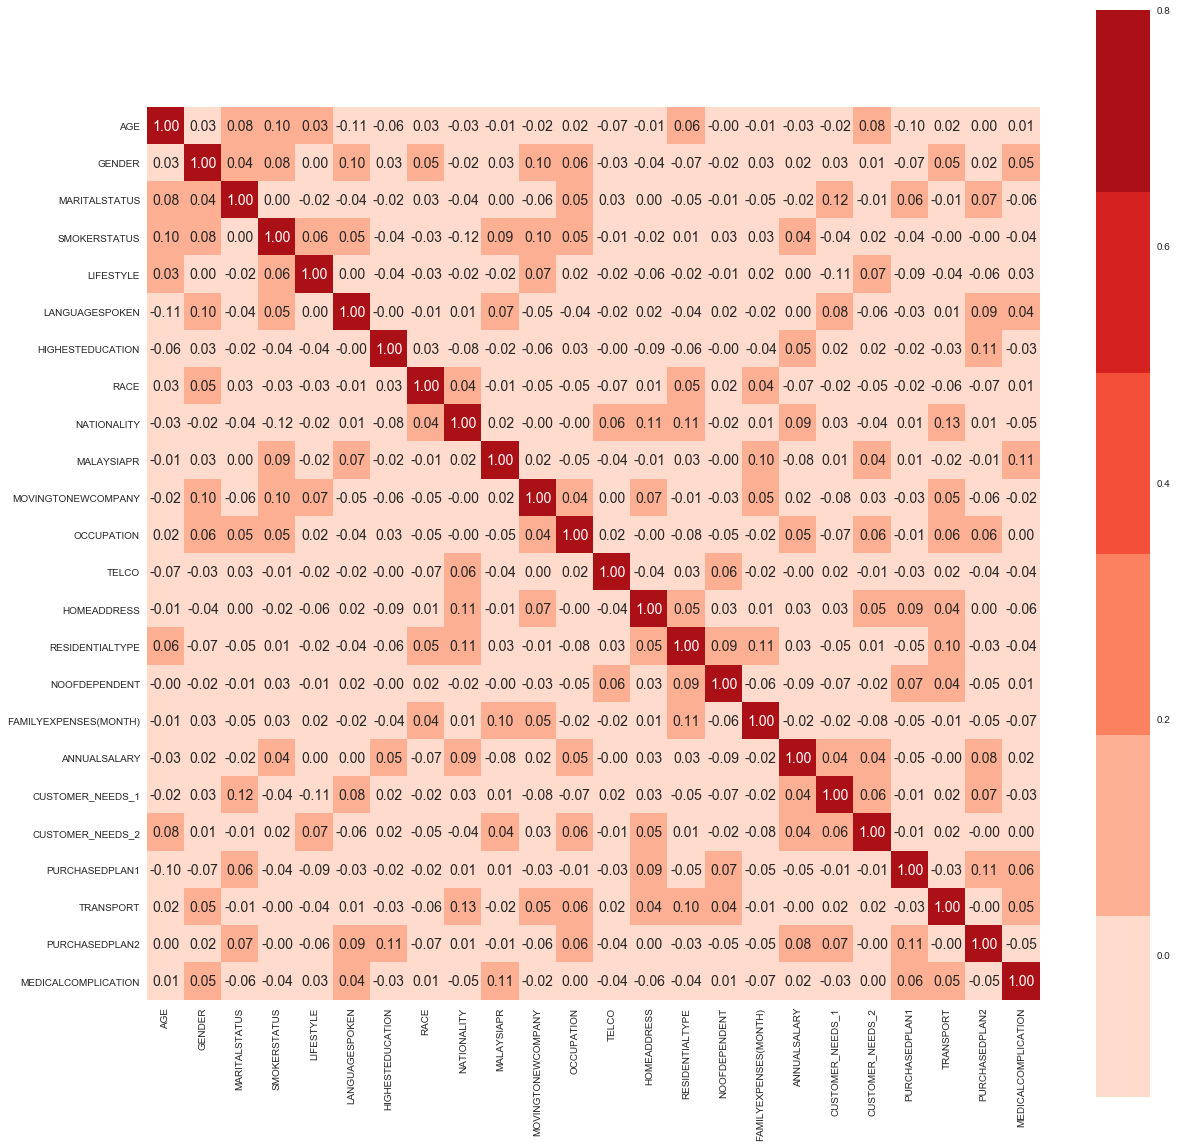

In [22]:
dfle
corr = dfle.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, vmax=.8, square=True, annot=True, fmt= '.2f',
           annot_kws={'size': 14}, cmap=sns.color_palette("Reds"))

### 1.4 Data Imbalanced Treatment

#### 1.4.1 Imbalanced Treatment for PurchasedPlan1

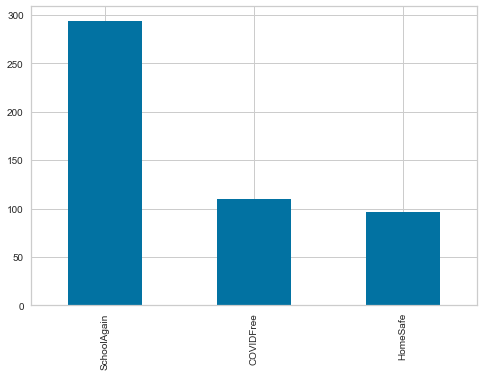

In [23]:
df["PURCHASEDPLAN1"].value_counts().plot(kind='bar')

2    241
1    241
0    241
Name: PURCHASEDPLAN1, dtype: int64


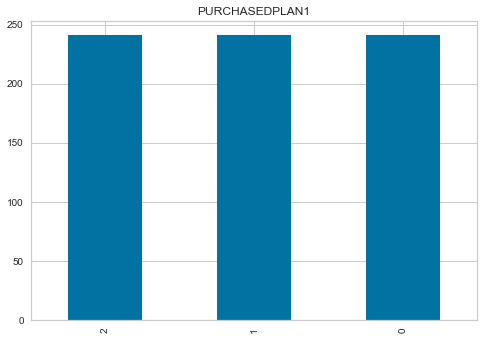

In [24]:
X = dfle.drop("PURCHASEDPLAN1", 1)
y = dfle["PURCHASEDPLAN1"]
features = X.columns
os = SMOTE(sampling_strategy="not majority", k_neighbors=5,random_state=10)
X_train, X_test, y_train, y_test = train_test_split(X,y.values.ravel(), test_size = 0.2, random_state=7)
X,y = os.fit_resample(X_train,y_train)
X = pd.DataFrame(data=X,columns=features)
y = pd.DataFrame(data=y,columns=['PURCHASEDPLAN1'])
y["PURCHASEDPLAN1"].value_counts().plot(kind="bar")
plt.title("PURCHASEDPLAN1")
print(y["PURCHASEDPLAN1"].value_counts())
y = pd.Series(y['PURCHASEDPLAN1'].values)

In [25]:
#Heat Map After Oversampling
#corr_matrix  = X.corr().abs()
#plt.figure(figsize=(30,30))
#sns.heatmap(corr_matrix, vmax=.8,
#           square=True, annot=True,
#           fmt= '.2f', annot_kws={'size':15},
#           cmap=sns.color_palette("Reds"))

#### 1.4.2 Imbalanced Treatment for PurchasedPlan2

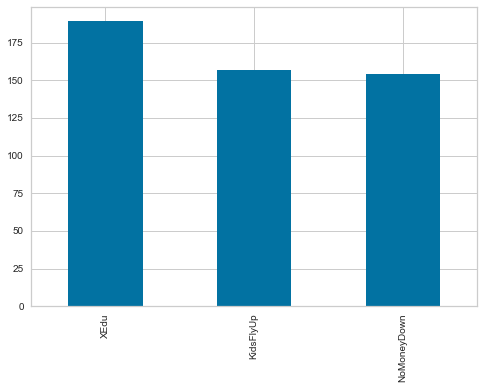

In [26]:
df["PURCHASEDPLAN2"].value_counts().plot(kind='bar')

2    167
1    167
0    167
Name: PURCHASEDPLAN2, dtype: int64


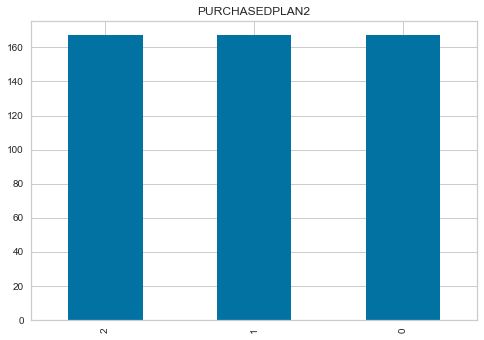

In [27]:
X2 = dfle.drop("PURCHASEDPLAN2", 1)
y2 = dfle["PURCHASEDPLAN2"]
features = X2.columns
os = SMOTE(sampling_strategy="not majority", k_neighbors=5, random_state=10)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2.values.ravel(), test_size = 0.1, random_state=7)
X2,y2 = os.fit_resample(X_train2,y_train2)
X2 = pd.DataFrame(data=X2,columns=features)
y2 = pd.DataFrame(data=y2,columns=['PURCHASEDPLAN2'])
y2["PURCHASEDPLAN2"].value_counts().plot(kind="bar")
plt.title("PURCHASEDPLAN2")
print(y2["PURCHASEDPLAN2"].value_counts())
y2 = pd.Series(y2['PURCHASEDPLAN2'].values)

In [28]:
#Heat Map After Oversampling
#corr_matrix  = X2.corr().abs()
#plt.figure(figsize=(30,30))
#sns.heatmap(corr_matrix, vmax=.8,
#           square=True, annot=True,
#           fmt= '.2f', annot_kws={'size':15},
#           cmap=sns.color_palette("Reds"))

In [29]:
#Inverse Transform
ydf = y.to_frame()
ydf.rename(columns={0: "PURCHASEDPLAN1"},inplace=True)
XmergedDf = X.merge(ydf, left_index=True, right_index=True)
XmergedDf[categorical_columns] = XmergedDf[categorical_columns].apply(lambda x: d[x.name].inverse_transform(x))
ydf2 = y2.to_frame()
ydf2.rename(columns={0: "PURCHASEDPLAN2"},inplace=True)
XmergedDf2 = X2.merge(ydf2, left_index=True, right_index=True)
XmergedDf2[categorical_columns] = XmergedDf2[categorical_columns].apply(lambda x: d[x.name].inverse_transform(x))

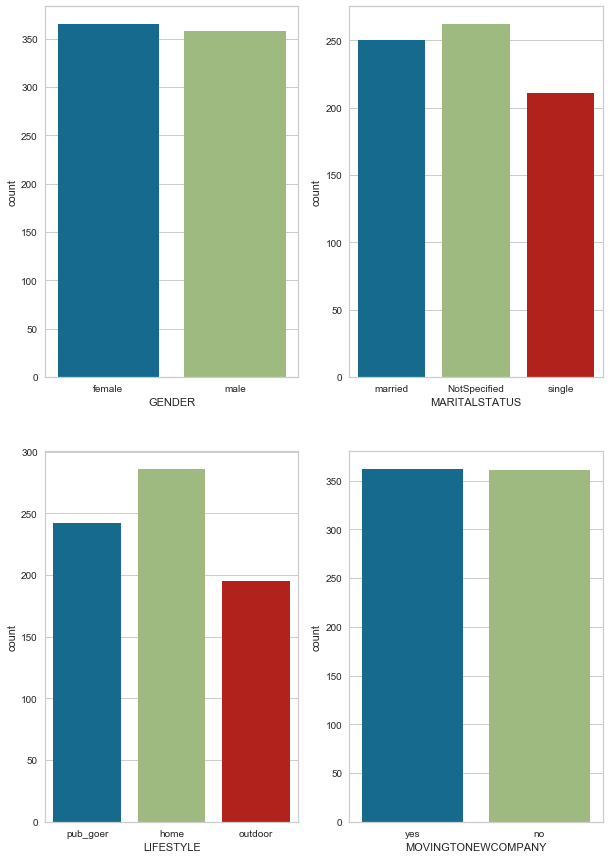

In [30]:
#Compare back to the original bar plot
categorical_columns_smote = XmergedDf[['GENDER', 'MARITALSTATUS', 
                       'LIFESTYLE', 'MOVINGTONEWCOMPANY']]
numeric_columns = XmergedDf[["AGE","NOOFDEPENDENT","FAMILYEXPENSES(MONTH)","ANNUALSALARY"]]
fig,axes = plt.subplots(2,2,figsize=(10,15))
for idx,cat_col in enumerate(categorical_columns_smote):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=XmergedDf,ax=axes[row,col])

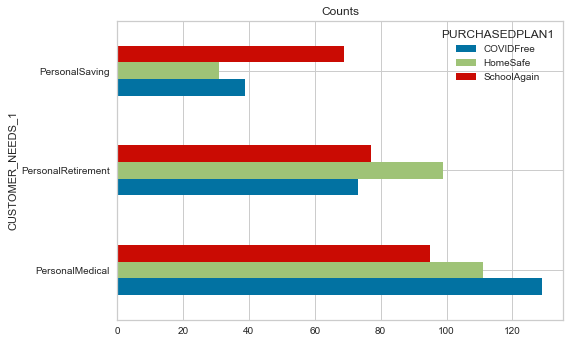

In [31]:
table=pd.crosstab(XmergedDf['CUSTOMER_NEEDS_1'], XmergedDf['PURCHASEDPLAN1'])
table.plot(kind='barh', title='Counts')
plt.show()

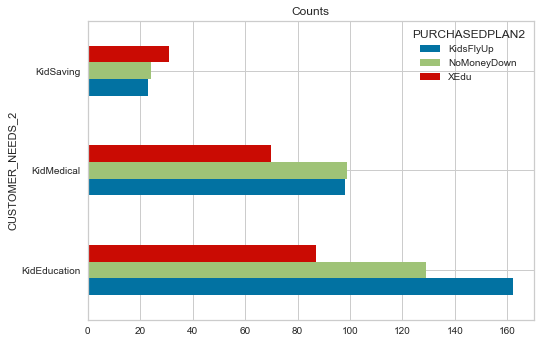

In [32]:
table=pd.crosstab(XmergedDf['CUSTOMER_NEEDS_2'], XmergedDf['PURCHASEDPLAN2'])
table.plot(kind='barh', title='Counts')
plt.show()

### THIS PART IS TO CHECK THE ACCURACY IF WE DO NOT SMOTE THE DATASET
#### MIGHT BE IGNORE

In [33]:
df_nosmote = df2.copy()
df_nosmote

,AGE,GENDER,MARITALSTATUS,SMOKERSTATUS,LIFESTYLE,LANGUAGESPOKEN,HIGHESTEDUCATION,RACE,NATIONALITY,MALAYSIAPR,...,FAMILYEXPENSES(MONTH),ANNUALSALARY,CUSTOMER_NEEDS_1,CUSTOMER_NEEDS_2,PURCHASEDPLAN1,TRANSPORT,PURCHASEDPLAN2,MEDICALCOMPLICATION,AGE_GROUP,SALARY(MONTH)
0,35.0,female,single,NotSpecified,home,english,Bachelor,malay,NotSpecified,yes,...,10242.00000,119040.678571,PersonalSaving,KidMedical,SchoolAgain,driving,NoMoneyDown,no,"(30.0, 40.0]",9920.056548
1,25.0,male,NotSpecified,NotSpecified,outdoor,malay,Diploma,chinese,Malaysian,no,...,6334.57265,73926.000000,PersonalRetirement,KidMedical,SchoolAgain,driving,XEdu,yes,"(20.0, 30.0]",6160.500000
2,27.0,male,NotSpecified,frequent,pub_goer,english,Bachelor,others,NotSpecified,no,...,4316.00000,140734.000000,PersonalMedical,KidMedical,SchoolAgain,driving,KidsFlyUp,yes,"(20.0, 30.0]",11727.833333
3,33.0,female,NotSpecified,once_in_a_while,pub_goer,english,Bachelor,malay,Malaysian,yes,...,4845.00000,119040.678571,PersonalSaving,KidSaving,SchoolAgain,driving,NoMoneyDown,no,"(30.0, 40.0]",9920.056548
4,28.0,female,NotSpecified,once_in_a_while,home,english,Bachelor,chinese,Malaysian,yes,...,9883.00000,98833.000000,PersonalRetirement,KidEducation,COVIDFree,driving,KidsFlyUp,yes,"(20.0, 30.0]",8236.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,31.0,female,married,frequent,outdoor,english,Diploma,NotSpecified,NotSpecified,yes,...,4831.00000,119040.678571,PersonalRetirement,KidMedical,HomeSafe,driving,KidsFlyUp,yes,NaN,9920.056548
496,26.0,male,married,frequent,home,english,Bachelor,others,NotSpecified,no,...,7455.00000,65384.000000,PersonalMedical,KidEducation,SchoolAgain,driving,KidsFlyUp,no,"(20.0, 30.0]",5448.666667
497,19.0,female,NotSpecified,frequent,home,malay,Diploma,others,NotSpecified,yes,...,3329.00000,51962.000000,PersonalSaving,KidEducation,COVIDFree,driving,KidsFlyUp,no,"(10.0, 20.0]",4330.166667
498,41.0,male,NotSpecified,once_in_a_while,pub_goer,malay,Bachelor,indian,Malaysian,yes,...,9300.00000,119040.678571,PersonalRetirement,KidSaving,COVIDFree,driving,KidsFlyUp,no,"(40.0, 50.0]",9920.056548


In [34]:
le = LabelEncoder()
d = defaultdict(LabelEncoder)
df_nosmote[categorical_columns] = df_nosmote[categorical_columns].apply(lambda x: d[x.name].fit_transform(x))

In [35]:
X3 = df_nosmote.drop("PURCHASEDPLAN1", 1)
y3 = df_nosmote["PURCHASEDPLAN1"]

In [36]:
X3.drop(["AGE_GROUP","SALARY(MONTH)"],1,inplace=True)

## 2.0 Feature Selection 

Feature selection is the process of reducing the number of input variables when developing a predictive model, in some cases, to improve the performance of the model as well.

Supervised: 
Use the target variable.
Wrapper: Search for well-performing subsets of features.
RFE

### 2.1 Feature Selection for X (PURCHASEDPLAN1)

#### 2.1.1 Boruta

In [37]:
print(X.shape)
print(y.shape)
print(X2.shape)
print(y2.shape)
print(X3.shape)
print(y3.shape)

(723, 23)
(723,)
(501, 23)
(501,)
(500, 23)
(500,)


In [38]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [39]:
#Boruta
rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth = 5)
feat_selector = BorutaPy(rf, n_estimators=100, random_state = 6)
feat_selector.fit(X.values, y.values.ravel())
colnames = X.columns
boruta_score = ranking(list(map(float, feat_selector.ranking_)), colnames, order=-1)
boruta_score = pd.DataFrame(list(boruta_score.items()), columns=['Features', 'Score'])
boruta_score = boruta_score.sort_values("Score", ascending = False)

In [40]:
print("Using the smote dataset for Feature Selection")
print('---------Top 5----------')
display(boruta_score.head(5))
print('---------Bottom 5----------')
boruta_score.tail(5)

Using the smote dataset for Feature Selection
---------Top 5----------


,Features,Score
0,AGE,1.0
3,SMOKERSTATUS,1.0
21,PURCHASEDPLAN2,1.0
17,ANNUALSALARY,1.0
16,FAMILYEXPENSES(MONTH),1.0


---------Bottom 5----------


,Features,Score
8,NATIONALITY,0.20
6,HIGHESTEDUCATION,0.13
1,GENDER,0.07
10,MOVINGTONEWCOMPANY,0.00
20,TRANSPORT,0.00


Text(0.5, 1, 'Boruta Top 20 Features')

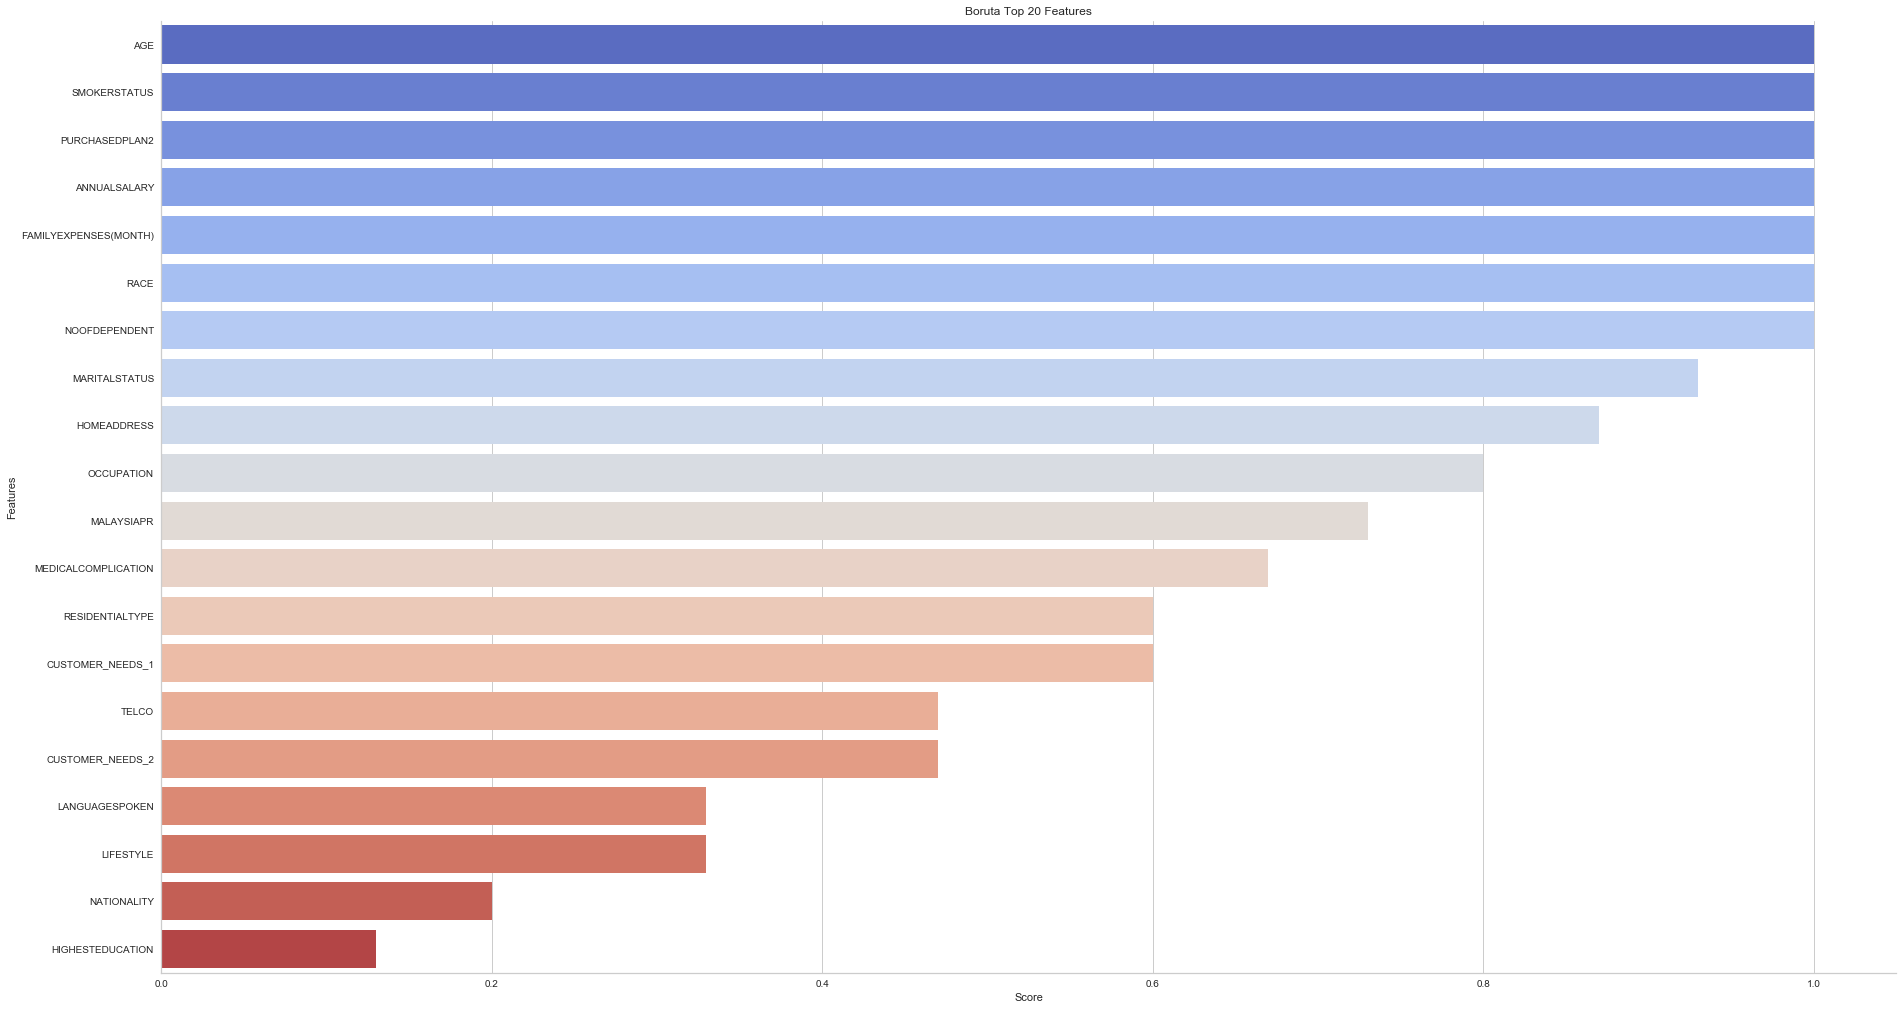

In [41]:
sns_boruta_plot = sns.catplot(x="Score", y="Features", data = boruta_score[0:20], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("Boruta Top 20 Features")

### 2.1.2 RFE

In [42]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=10, n_estimators=100, random_state=10)
rf.fit(X, y)
rfe = RFECV(rf, min_features_to_select=1, cv=3)
rfe.fit(X,y)
rfe_score = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)
rfe_score = pd.DataFrame(list(rfe_score.items()), columns=['Features','Score'])
rfe_score = rfe_score.sort_values("Score",ascending = False)
print('---------Top 5----------')
display(rfe_score.head(5))
print('---------Bottom 5----------')
rfe_score.tail(5)

---------Top 5----------


,Features,Score
0,AGE,1.0
1,GENDER,1.0
21,PURCHASEDPLAN2,1.0
19,CUSTOMER_NEEDS_2,1.0
18,CUSTOMER_NEEDS_1,1.0


---------Bottom 5----------


,Features,Score
3,SMOKERSTATUS,1.0
2,MARITALSTATUS,1.0
22,MEDICALCOMPLICATION,1.0
10,MOVINGTONEWCOMPANY,0.5
20,TRANSPORT,0.0


Text(0.5, 1, 'RFE Top 20 Features')

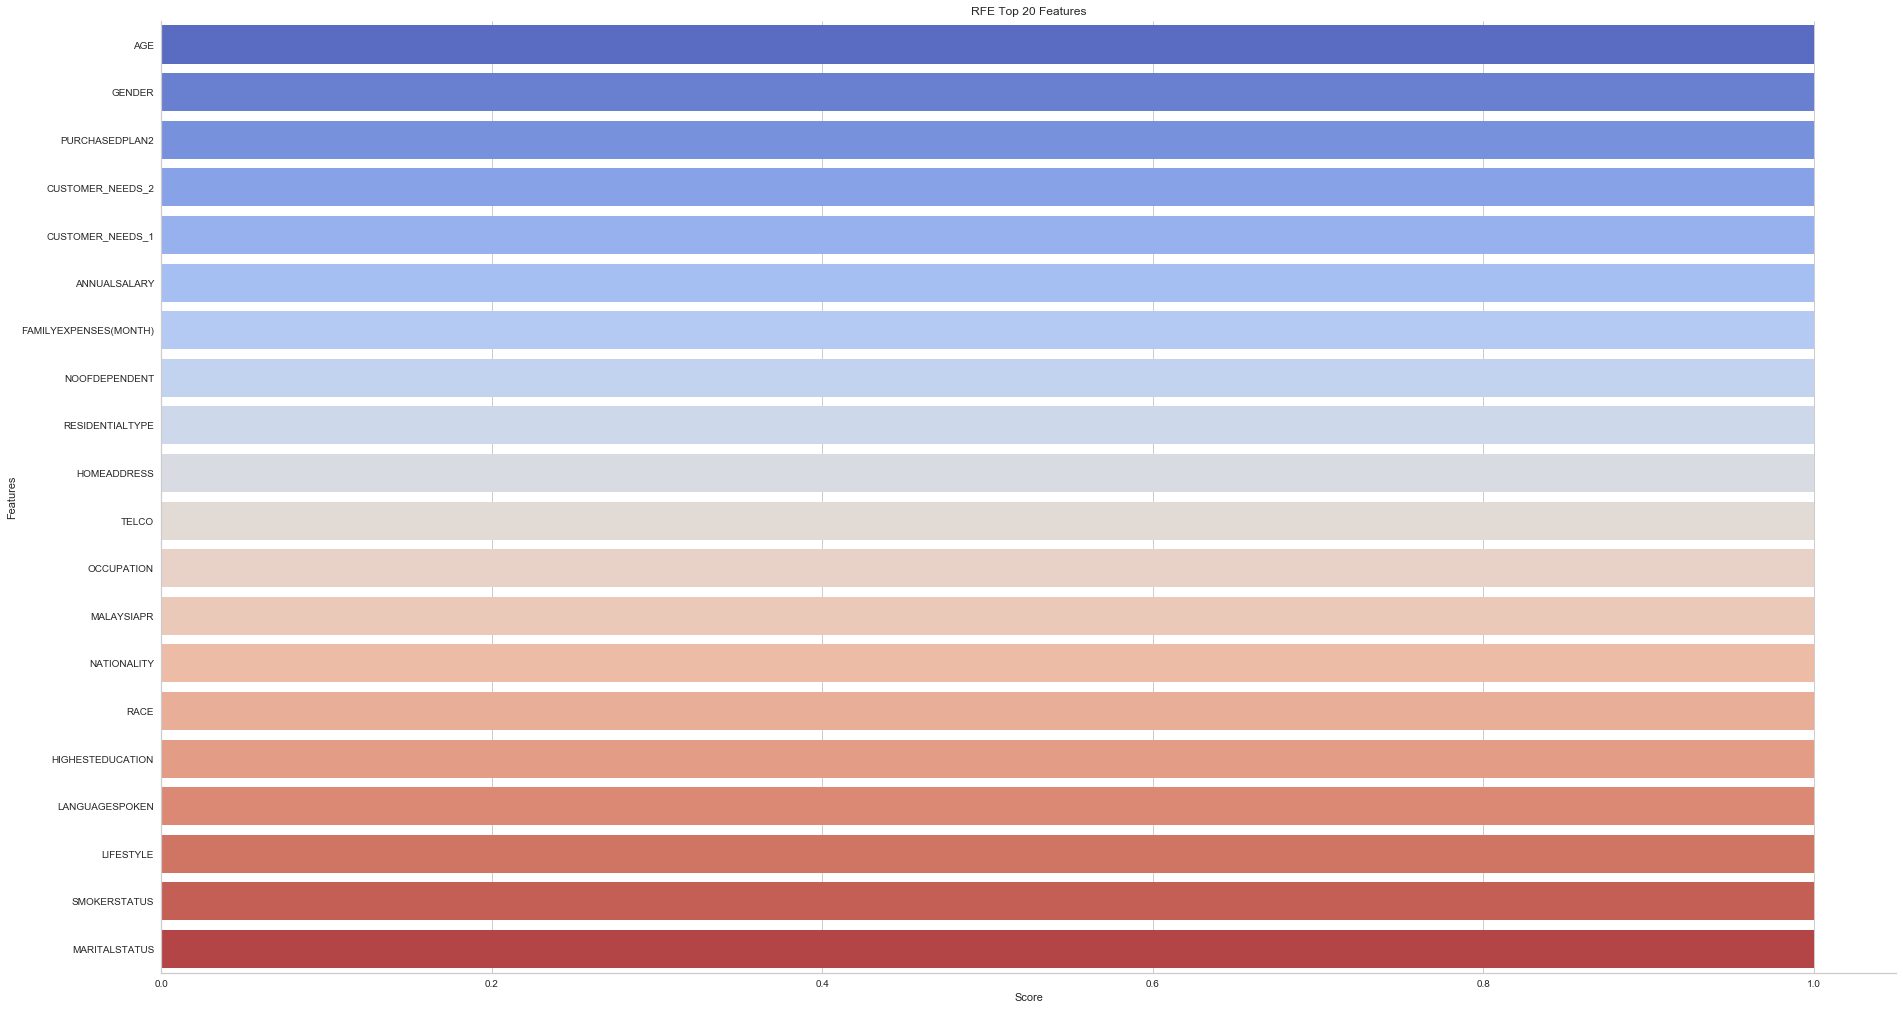

In [43]:
sns_rfe_plot = sns.catplot(x="Score", y="Features", data = rfe_score[0:20], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("RFE Top 20 Features")

### 2.2 Feature Selection for X2 (PURCHASEDPLAN2)

#### 2.2.1 Boruta

In [44]:
#Select Feature for X2, PURCHASEDPLAN2
feat_selector = BorutaPy(rf, n_estimators=100, random_state = 6)
feat_selector.fit(X2.values, y2.values.ravel())
colnames2 = X2.columns
boruta_score2 = ranking(list(map(float, feat_selector.ranking_)), colnames2, order=-1)
boruta_score2 = pd.DataFrame(list(boruta_score2.items()), columns=['Features', 'Score'])
boruta_score2 = boruta_score2.sort_values("Score", ascending = False)
print("Using the smote dataset for Feature Selection")
print('---------Top 5----------')
display(boruta_score2.head(5))
print('---------Bottom 5----------')
boruta_score2.tail(5)

Using the smote dataset for Feature Selection
---------Top 5----------


,Features,Score
16,FAMILYEXPENSES(MONTH),1.00
17,ANNUALSALARY,0.95
0,AGE,0.91
7,RACE,0.86
13,HOMEADDRESS,0.82


---------Bottom 5----------


,Features,Score
1,GENDER,0.18
10,MOVINGTONEWCOMPANY,0.14
22,MEDICALCOMPLICATION,0.09
9,MALAYSIAPR,0.05
21,TRANSPORT,0.00


Text(0.5, 1, 'Boruta Top 20 Features')

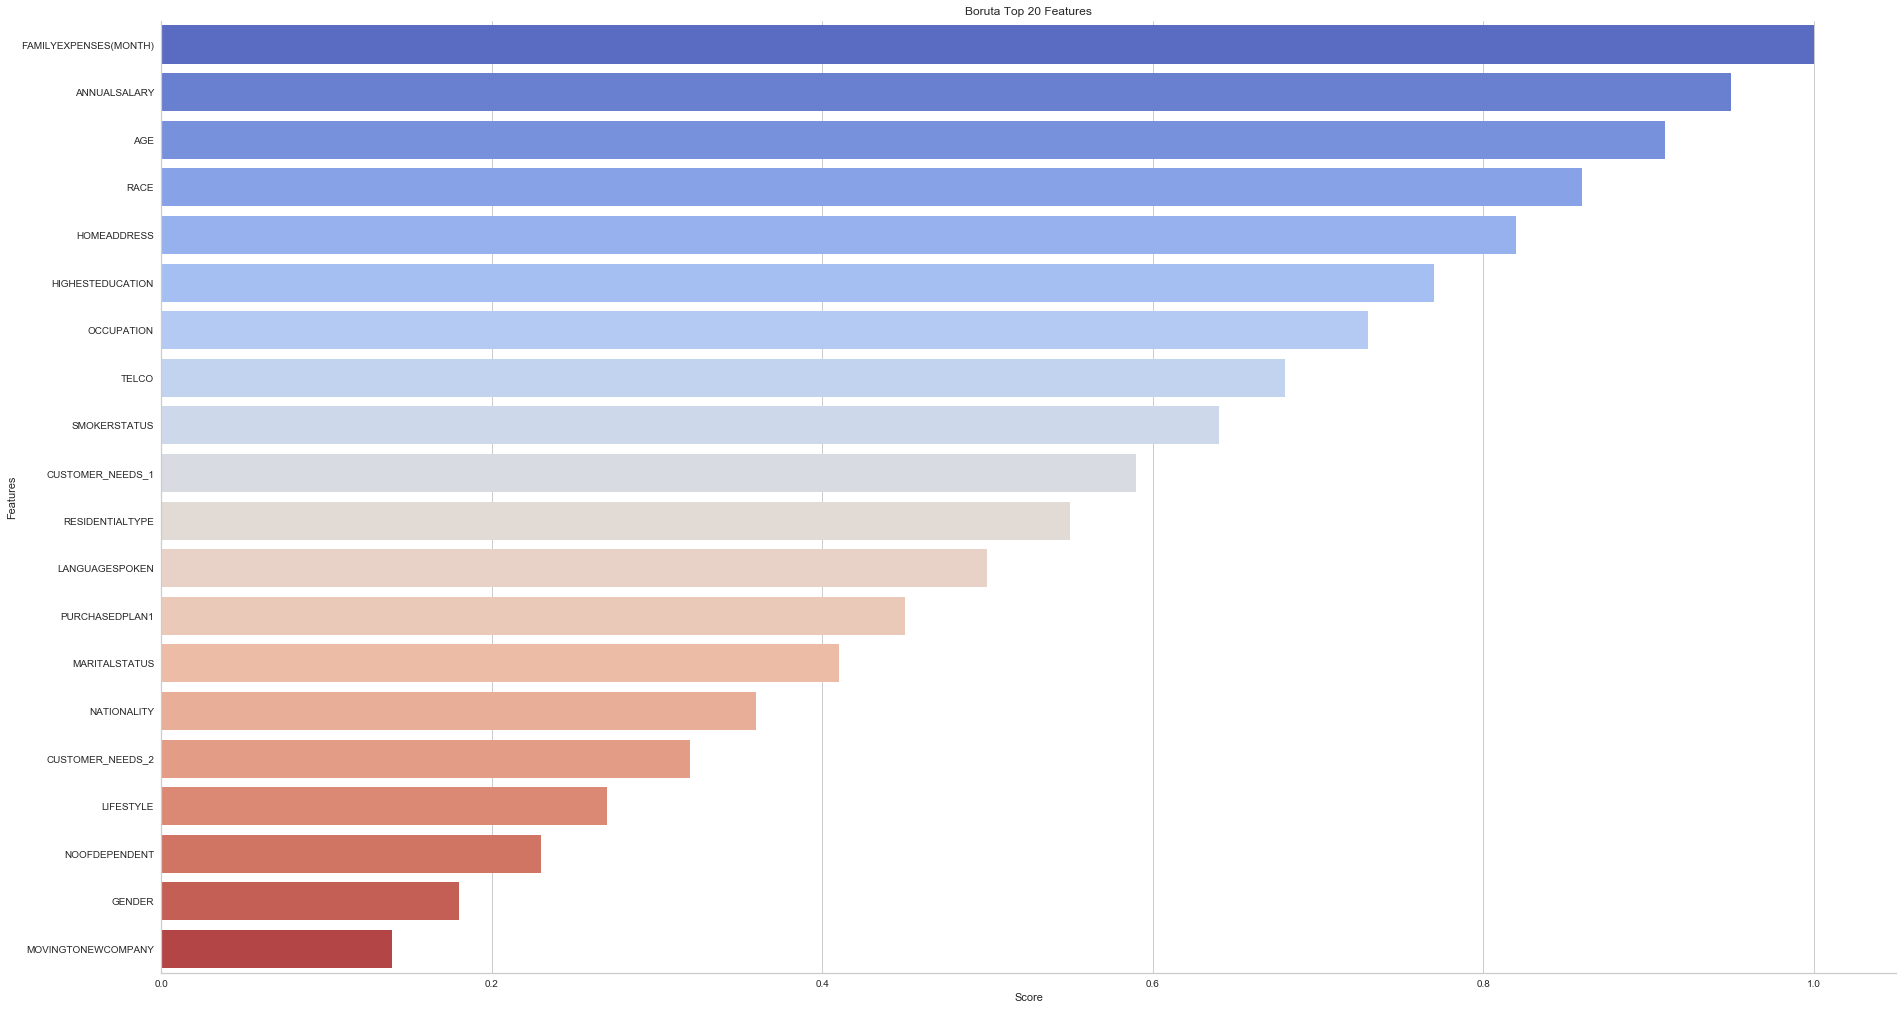

In [45]:
sns_boruta_plot = sns.catplot(x="Score", y="Features", data = boruta_score2[0:20], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("Boruta Top 20 Features")

#### 2.2.2 RFE

In [46]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=10, n_estimators=100, random_state=10)
rf.fit(X2, y2)
rfe = RFECV(rf, min_features_to_select=1, cv=3)
rfe.fit(X2,y2)
rfe_score2 = ranking(list(map(float, rfe.ranking_)), colnames2, order=-1)
rfe_score2 = pd.DataFrame(list(rfe_score2.items()), columns=['Features','Score'])
rfe_score2 = rfe_score2.sort_values("Score",ascending = False)
print('---------Top 5----------')
display(rfe_score2.head(5))
print('---------Bottom 5----------')
rfe_score2.tail(5)

---------Top 5----------


,Features,Score
0,AGE,1.0
1,GENDER,1.0
20,PURCHASEDPLAN1,1.0
19,CUSTOMER_NEEDS_2,1.0
18,CUSTOMER_NEEDS_1,1.0


---------Bottom 5----------


,Features,Score
2,MARITALSTATUS,1.00
22,MEDICALCOMPLICATION,0.75
10,MOVINGTONEWCOMPANY,0.50
21,TRANSPORT,0.25
9,MALAYSIAPR,0.00


Text(0.5, 1, 'RFE Top 20 Features')

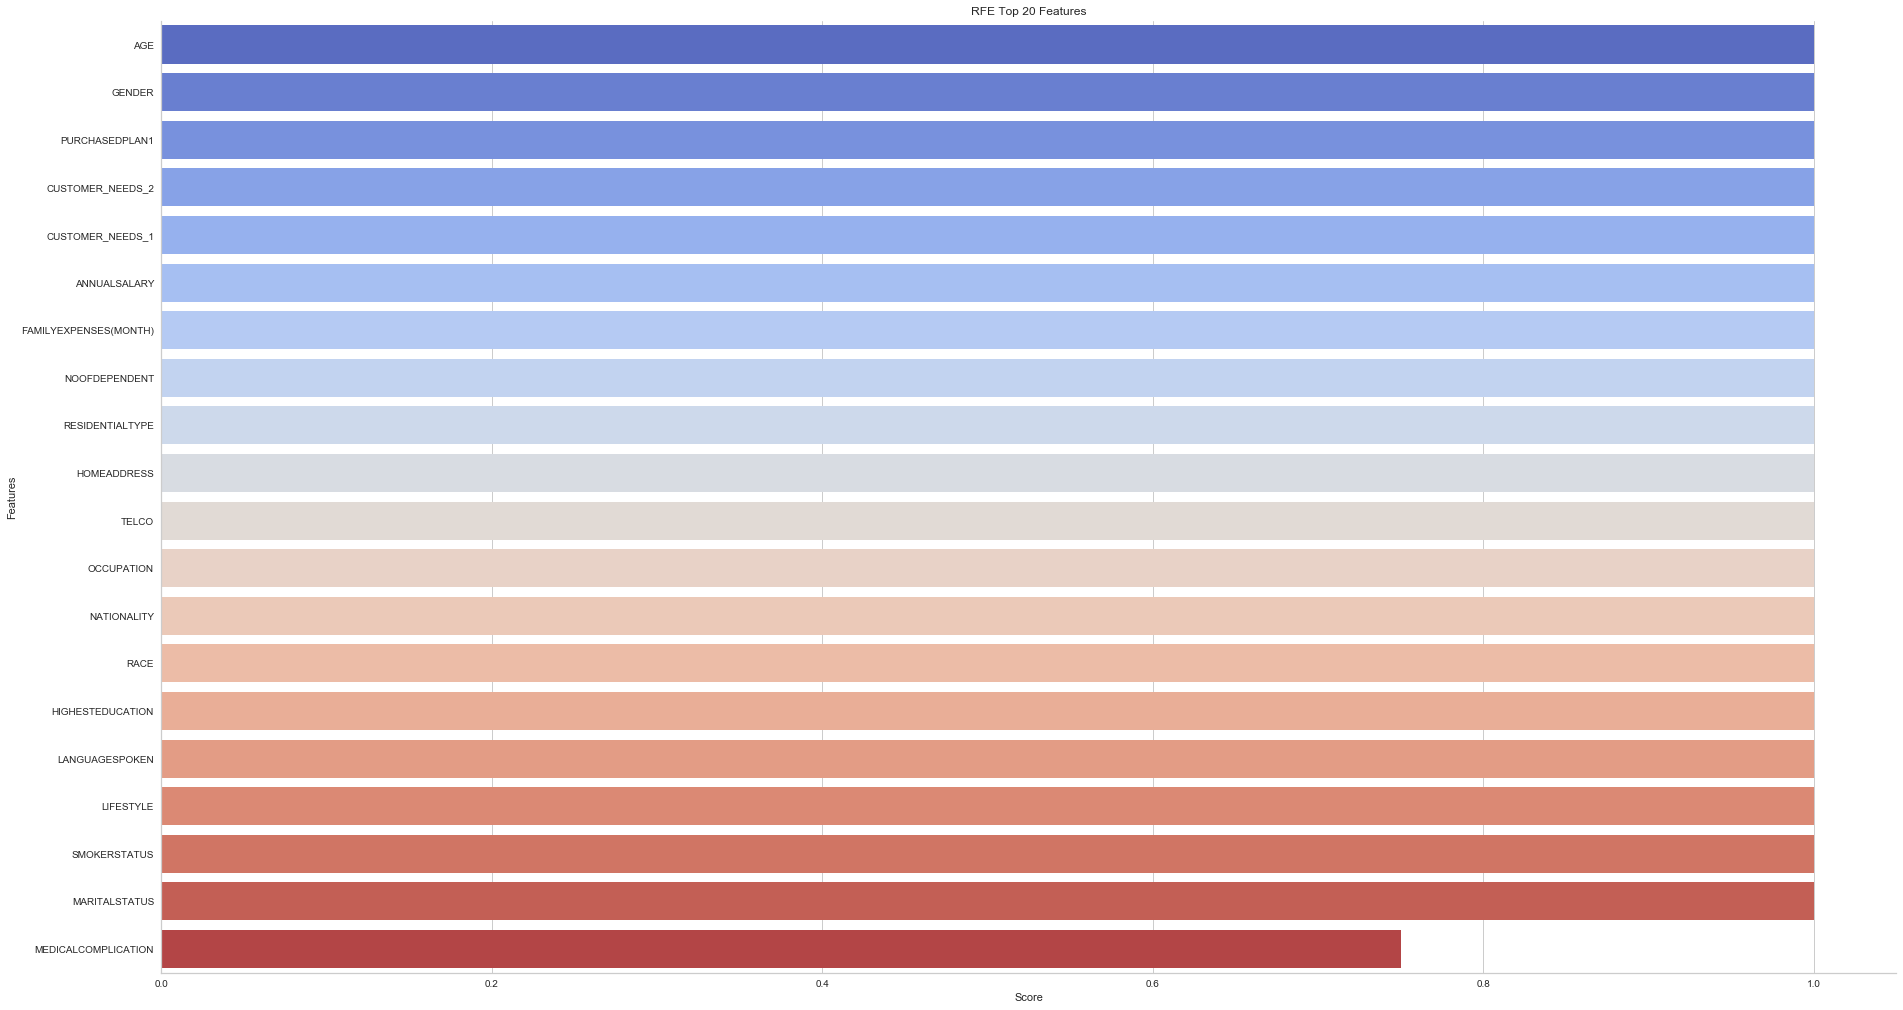

In [47]:
sns_rfe_plot = sns.catplot(x="Score", y="Features", data = rfe_score2[0:20], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("RFE Top 20 Features")

#### 2.2 Optimal Features Selection

In [48]:
#Drop the least important features from boruta and rfe
X.drop(columns=['TRANSPORT', 'GENDER','MOVINGTONEWCOMPANY','HIGHESTEDUCATION'], inplace=True)
X2.drop(columns=['TRANSPORT', 'MOVINGTONEWCOMPANY','MEDICALCOMPLICATION','MALAYSIAPR',"GENDER"], inplace=True)

In [49]:
X.columns

Index(['AGE', 'MARITALSTATUS', 'SMOKERSTATUS', 'LIFESTYLE', 'LANGUAGESPOKEN',
       'RACE', 'NATIONALITY', 'MALAYSIAPR', 'OCCUPATION', 'TELCO',
       'HOMEADDRESS', 'RESIDENTIALTYPE', 'NOOFDEPENDENT',
       'FAMILYEXPENSES(MONTH)', 'ANNUALSALARY', 'CUSTOMER_NEEDS_1',
       'CUSTOMER_NEEDS_2', 'PURCHASEDPLAN2', 'MEDICALCOMPLICATION'],
      dtype='object')

In [50]:
X2.columns

Index(['AGE', 'MARITALSTATUS', 'SMOKERSTATUS', 'LIFESTYLE', 'LANGUAGESPOKEN',
       'HIGHESTEDUCATION', 'RACE', 'NATIONALITY', 'OCCUPATION', 'TELCO',
       'HOMEADDRESS', 'RESIDENTIALTYPE', 'NOOFDEPENDENT',
       'FAMILYEXPENSES(MONTH)', 'ANNUALSALARY', 'CUSTOMER_NEEDS_1',
       'CUSTOMER_NEEDS_2', 'PURCHASEDPLAN1'],
      dtype='object')

### THIS PART IS TO CHECK THE ACCURACY IF WE DO NOT SMOTE THE DATASET )
#### MIGHT BE IGNORE

In [51]:
#Boruta
rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth = 5)
feat_selector = BorutaPy(rf, n_estimators=100, random_state = 6)
feat_selector.fit(X3.values, y3.values.ravel())
colnames3 = X3.columns
boruta_score3 = ranking(list(map(float, feat_selector.ranking_)), colnames3, order=-1)
boruta_score3 = pd.DataFrame(list(boruta_score3.items()), columns=['Features', 'Score'])
boruta_score3 = boruta_score3.sort_values("Score", ascending = False)

print("Using the smote dataset for Feature Selection")
print('---------Top 5----------')
display(boruta_score3.head(5))
print('---------Bottom 5----------')
boruta_score3.tail(5)

Using the smote dataset for Feature Selection
---------Top 5----------


,Features,Score
0,AGE,1.00
16,FAMILYEXPENSES(MONTH),0.95
17,ANNUALSALARY,0.91
13,HOMEADDRESS,0.86
3,SMOKERSTATUS,0.82


---------Bottom 5----------


,Features,Score
18,CUSTOMER_NEEDS_1,0.18
1,GENDER,0.14
10,MOVINGTONEWCOMPANY,0.09
22,MEDICALCOMPLICATION,0.09
20,TRANSPORT,0.00


In [52]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=10, n_estimators=100, random_state=10)
rf.fit(X3, y3)
rfe = RFECV(rf, min_features_to_select=1, cv=3)
rfe.fit(X3,y3)
rfe_score3 = ranking(list(map(float, rfe.ranking_)), colnames3, order=-1)
rfe_score3 = pd.DataFrame(list(rfe_score3.items()), columns=['Features','Score'])
rfe_score3 = rfe_score3.sort_values("Score",ascending = False)

In [53]:
print('---------Top 5----------')
display(rfe_score3.head(5))
print('---------Bottom 5----------')
rfe_score3.tail(5)

---------Top 5----------


,Features,Score
0,AGE,1.0
12,TELCO,1.0
21,PURCHASEDPLAN2,1.0
20,TRANSPORT,1.0
19,CUSTOMER_NEEDS_2,1.0


---------Bottom 5----------


,Features,Score
4,LIFESTYLE,1.0
3,SMOKERSTATUS,1.0
2,MARITALSTATUS,1.0
22,MEDICALCOMPLICATION,1.0
9,MALAYSIAPR,0.0


In [54]:
X3.drop(columns=['TRANSPORT', 'MOVINGTONEWCOMPANY','MEDICALCOMPLICATION','MALAYSIAPR'], inplace=True)

In [55]:
X3.columns

Index(['AGE', 'GENDER', 'MARITALSTATUS', 'SMOKERSTATUS', 'LIFESTYLE',
       'LANGUAGESPOKEN', 'HIGHESTEDUCATION', 'RACE', 'NATIONALITY',
       'OCCUPATION', 'TELCO', 'HOMEADDRESS', 'RESIDENTIALTYPE',
       'NOOFDEPENDENT', 'FAMILYEXPENSES(MONTH)', 'ANNUALSALARY',
       'CUSTOMER_NEEDS_1', 'CUSTOMER_NEEDS_2', 'PURCHASEDPLAN2'],
      dtype='object')

##  3.0 Machine Learning Techniques

### 3.1 Classification for Purchaseplan1

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, test_size = 0.3, random_state=7)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,y3, test_size = 0.3, random_state=7)

#### 3.1.1 Random Forest Classifier (After SMOTE)

In [57]:
rf = RandomForestClassifier(random_state=16, max_depth = 13)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
prob_RF = rf.predict_proba(X_test)
prob_RF = prob_RF
auc_RF= roc_auc_score(y_test, prob_RF, average='weighted', multi_class='ovr')
print("Accuracy on training set : {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set     : {:.3f}".format(rf.score(X_test, y_test)))
print('AUC: %.2f' % auc_RF)
confusion_majority=confusion_matrix(y_test, y_pred)
print('Majority classifier Confusion Matrix\n', confusion_majority)
print("=====================================================")
#print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='macro')))
#print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='macro')))
#print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='macro')))
#print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))
target_names = ['Class 0', 'Class 1', 'Class 2']
print(classification_report(y_test, y_pred, target_names=target_names))
print("=====================================================")

Accuracy on training set : 1.000
Accuracy on test set     : 0.825
AUC: 0.92
Majority classifier Confusion Matrix
 [[62  2 11]
 [ 2 62  8]
 [ 9  6 55]]
              precision    recall  f1-score   support

     Class 0       0.85      0.83      0.84        75
     Class 1       0.89      0.86      0.87        72
     Class 2       0.74      0.79      0.76        70

    accuracy                           0.82       217
   macro avg       0.83      0.82      0.82       217
weighted avg       0.83      0.82      0.83       217



#### 3.1.2 Naive Bayes Classifier (After SMOTE)

In [58]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
prob_NB = nb.predict_proba(X_test)
prob_NB = prob_NB
auc_NB= roc_auc_score(y_test, prob_NB, average='weighted', multi_class='ovr')
print("Accuracy on training set : {:.3f}".format(nb.score(X_train, y_train)))
print("Accuracy on test set     : {:.3f}".format(nb.score(X_test, y_test)))
print('AUC: %.2f' % auc_NB)
confusion_majority=confusion_matrix(y_test, y_pred)
print('Majority classifier Confusion Matrix\n', confusion_majority)
print("=====================================================")
#print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='macro')))
#print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='macro')))
#print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='macro')))
#print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))
target_names = ['Class 0', 'Class 1', 'Class 2']
print(classification_report(y_test, y_pred, target_names=target_names))
print("=====================================================")

Accuracy on training set : 0.589
Accuracy on test set     : 0.548
AUC: 0.75
Majority classifier Confusion Matrix
 [[36 16 23]
 [15 41 16]
 [14 14 42]]
              precision    recall  f1-score   support

     Class 0       0.55      0.48      0.51        75
     Class 1       0.58      0.57      0.57        72
     Class 2       0.52      0.60      0.56        70

    accuracy                           0.55       217
   macro avg       0.55      0.55      0.55       217
weighted avg       0.55      0.55      0.55       217



#### 3.1.3 KNN Classifier (After Smote)

In [59]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
prob_KNN = knn.predict_proba(X_test)
auc_KNN = roc_auc_score(y_test, prob_KNN, multi_class="ovr")
print("Accuracy on training set : {:.3f}".format(knn.score(X_train, y_train)))
print("Accuracy on test set     : {:.3f}".format(knn.score(X_test, y_test)))
print('AUC: %.2f' % auc_KNN)
confusion_majority=confusion_matrix(y_test, y_pred)
print('Majority classifier Confusion Matrix\n', confusion_majority)
#print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='macro')))
#print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='macro')))
#print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='macro')))
#print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))
print("=====================================================")
#print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='macro')))
#print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='macro')))
#print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='macro')))
#print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))
target_names = ['Class 0', 'Class 1', 'Class 2']
print(classification_report(y_test, y_pred, target_names=target_names))
print("=====================================================")

Accuracy on training set : 0.704
Accuracy on test set     : 0.641
AUC: 0.83
Majority classifier Confusion Matrix
 [[62 12  1]
 [11 58  3]
 [19 32 19]]
              precision    recall  f1-score   support

     Class 0       0.67      0.83      0.74        75
     Class 1       0.57      0.81      0.67        72
     Class 2       0.83      0.27      0.41        70

    accuracy                           0.64       217
   macro avg       0.69      0.63      0.61       217
weighted avg       0.69      0.64      0.61       217



#### 3.1.4 SVM Classifier (After Smote)

In [60]:
model = SVC(kernel = 'rbf', gamma = 'auto', probability=True)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
prob_SVM = model.predict_proba(X_test)
auc_SVM = roc_auc_score(y_test, prob_SVM, multi_class="ovr")
print("Accuracy on training set : {:.3f}".format(model.score(X_train, y_train)))
print("Accuracy on test set     : {:.3f}".format(model.score(X_test, y_test)))
print('AUC: %.2f' % auc_SVM)
confusion_majority=confusion_matrix(y_test, y_pred)
print('Majority classifier Confusion Matrix\n', confusion_majority)
#print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='macro')))
#print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='macro')))
#print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='macro')))
#print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))

print("=====================================================")
#print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='macro')))
#print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='macro')))
#print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='macro')))
#print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))
target_names = ['Class 0', 'Class 1', 'Class 2']
print(classification_report(y_test, y_pred, target_names=target_names))
print("=====================================================")

Accuracy on training set : 0.931
Accuracy on test set     : 0.756
AUC: 0.91
Majority classifier Confusion Matrix
 [[58  3 14]
 [ 2 62  8]
 [10 16 44]]
              precision    recall  f1-score   support

     Class 0       0.83      0.77      0.80        75
     Class 1       0.77      0.86      0.81        72
     Class 2       0.67      0.63      0.65        70

    accuracy                           0.76       217
   macro avg       0.75      0.75      0.75       217
weighted avg       0.76      0.76      0.75       217



### 3.2 Classification for purchasedplan2

#### 3.2.1 Random Forest Classifier  (After Smote)

In [61]:
rf.fit(X_train2, y_train2)
y_pred2 = rf.predict(X_test2)
prob_RF2 = rf.predict_proba(X_test2)
auc_RF2 = roc_auc_score(y_test2, prob_RF2, average='weighted', multi_class='ovr')
print("Accuracy on training set : {:.3f}".format(rf.score(X_train2, y_train2)))
print("Accuracy on test set     : {:.3f}".format(rf.score(X_test2, y_test2)))
print('AUC: %.2f' % auc_RF2)
confusion_majority=confusion_matrix(y_test2, y_pred2)
print('Majority classifier Confusion Matrix\n', confusion_majority)
print("=====================================================")
#print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='macro')))
#print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='macro')))
#print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='macro')))
#print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))
target_names = ['Class 0', 'Class 1', 'Class 2']
print(classification_report(y_test2, y_pred2, target_names=target_names))
print("=====================================================")

Accuracy on training set : 1.000
Accuracy on test set     : 0.404
AUC: 0.64
Majority classifier Confusion Matrix
 [[33 13  5]
 [15 16 13]
 [19 25 12]]
              precision    recall  f1-score   support

     Class 0       0.49      0.65      0.56        51
     Class 1       0.30      0.36      0.33        44
     Class 2       0.40      0.21      0.28        56

    accuracy                           0.40       151
   macro avg       0.40      0.41      0.39       151
weighted avg       0.40      0.40      0.39       151



#### 3.2.2 Naive Bayes Classifier  (After Smote)

In [62]:
nb = GaussianNB()
nb.fit(X_train2, y_train2)
y_pred2 = nb.predict(X_test2)
prob_NB2 = nb.predict_proba(X_test2)
auc_NB2 = roc_auc_score(y_test2, prob_NB2, average='weighted', multi_class='ovr')
print("Accuracy on training set : {:.3f}".format(nb.score(X_train2, y_train2)))
print("Accuracy on test set     : {:.3f}".format(nb.score(X_test2, y_test2)))
print('AUC: %.2f' % auc_NB2)
confusion_majority = confusion_matrix(y_test2, y_pred2)
print('Majority classifier Confusion Matrix\n', confusion_majority)
print("=====================================================")
#print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='macro')))
#print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='macro')))
#print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='macro')))
#print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))
target_names = ['Class 0', 'Class 1', 'Class 2']
print(classification_report(y_test2, y_pred2, target_names=target_names))
print("=====================================================")

Accuracy on training set : 0.517
Accuracy on test set     : 0.430
AUC: 0.59
Majority classifier Confusion Matrix
 [[31 13  7]
 [16 15 13]
 [16 21 19]]
              precision    recall  f1-score   support

     Class 0       0.49      0.61      0.54        51
     Class 1       0.31      0.34      0.32        44
     Class 2       0.49      0.34      0.40        56

    accuracy                           0.43       151
   macro avg       0.43      0.43      0.42       151
weighted avg       0.44      0.43      0.43       151



#### 3.2.3 KNN Classification  (After Smote)

In [63]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train2, y_train2)
y_pred2 = knn.predict(X_test2)
prob_KNN2 = knn.predict_proba(X_test2)
auc_KNN2 = roc_auc_score(y_test2, prob_KNN2, multi_class="ovr")
print("Accuracy on training set : {:.3f}".format(knn.score(X_train2, y_train2)))
print("Accuracy on test set     : {:.3f}".format(knn.score(X_test2, y_test2)))
print('AUC: %.2f' % auc_KNN2)
confusion_majority=confusion_matrix(y_test2, y_pred2)
print('Majority classifier Confusion Matrix\n', confusion_majority)
#print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='macro')))
#print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='macro')))
#print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='macro')))
#print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))
print("=====================================================")
#print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='macro')))
#print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='macro')))
#print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='macro')))
#print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))
target_names = ['Class 0', 'Class 1', 'Class 2']
print(classification_report(y_test2, y_pred2, target_names=target_names))
print("=====================================================")

Accuracy on training set : 0.554
Accuracy on test set     : 0.477
AUC: 0.65
Majority classifier Confusion Matrix
 [[36  9  6]
 [14 26  4]
 [25 21 10]]
              precision    recall  f1-score   support

     Class 0       0.48      0.71      0.57        51
     Class 1       0.46      0.59      0.52        44
     Class 2       0.50      0.18      0.26        56

    accuracy                           0.48       151
   macro avg       0.48      0.49      0.45       151
weighted avg       0.48      0.48      0.44       151



#### 3.2.4 SVM Classification  (After Smote)

In [64]:
model = SVC(kernel = 'rbf', gamma = 'auto', probability=True)
model.fit(X_train2,y_train2)
y_pred2 = model.predict(X_test2)
prob_SVM2 = model.predict_proba(X_test2)
auc_SVM2 = roc_auc_score(y_test2, prob_SVM2, multi_class="ovr")
print("Accuracy on training set : {:.3f}".format(model.score(X_train2, y_train2)))
print("Accuracy on test set     : {:.3f}".format(model.score(X_test2, y_test2)))
print('AUC: %.2f' % auc_SVM2)
confusion_majority2=confusion_matrix(y_test2, y_pred2)
print('Majority classifier Confusion Matrix\n', confusion_majority2)
#print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='macro')))
#print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='macro')))
#print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='macro')))
#print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))
print("=====================================================")
#print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='macro')))
#print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='macro')))
#print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='macro')))
#print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))
target_names = ['Class 0', 'Class 1', 'Class 2']
print(classification_report(y_test2, y_pred2, target_names=target_names))
print("=====================================================")

Accuracy on training set : 0.869
Accuracy on test set     : 0.430
AUC: 0.59
Majority classifier Confusion Matrix
 [[30 12  9]
 [14 22  8]
 [14 29 13]]
              precision    recall  f1-score   support

     Class 0       0.52      0.59      0.55        51
     Class 1       0.35      0.50      0.41        44
     Class 2       0.43      0.23      0.30        56

    accuracy                           0.43       151
   macro avg       0.43      0.44      0.42       151
weighted avg       0.44      0.43      0.42       151



### THIS PART IS TO CHECK THE ACCURACY IF WE DONOT SMOTE THE DATASET 
#### MIGHT BE IGNORE

In [65]:
rf.fit(X_train3, y_train3)
y_pred3 = rf.predict(X_test3)
prob_RF3 = rf.predict_proba(X_test3)
auc_RF3 = roc_auc_score(y_test3, prob_RF3, average='weighted', multi_class='ovr')
print("Accuracy on training set : {:.3f}".format(rf.score(X_train3, y_train3)))
print("Accuracy on test set     : {:.3f}".format(rf.score(X_test3, y_test3)))
print('AUC: %.3f' % auc_RF3)
confusion_majority=confusion_matrix(y_test3, y_pred3)
print('Majority classifier Confusion Matrix\n', confusion_majority)
print("=====================================================")
#print('Precision= {:.3f}'.format(precision_score(y_test, y_pred,average='macro')))
#print('Recall= {:.3f}'. format(recall_score(y_test, y_pred,average='macro')))
#print('F1= {:.3f}'. format(f1_score(y_test, y_pred,average='macro')))
#print('Accuracy= {:.3f}'. format(accuracy_score(y_test, y_pred)))
target_names = ['Class 0', 'Class 1', 'Class 3']
print(classification_report(y_test3, y_pred3, target_names=target_names))
print("=====================================================")

Accuracy on training set : 1.000
Accuracy on test set     : 0.560
AUC: 0.582
Majority classifier Confusion Matrix
 [[ 1  1 36]
 [ 1  1 25]
 [ 1  2 82]]
              precision    recall  f1-score   support

     Class 0       0.33      0.03      0.05        38
     Class 1       0.25      0.04      0.06        27
     Class 3       0.57      0.96      0.72        85

    accuracy                           0.56       150
   macro avg       0.39      0.34      0.28       150
weighted avg       0.45      0.56      0.43       150



In [66]:
nb = GaussianNB()
nb.fit(X_train3, y_train3)
y_pred3 = nb.predict(X_test3)
prob_NB3 = nb.predict_proba(X_test3)
auc_NB3 = roc_auc_score(y_test3, prob_NB3, average='weighted', multi_class='ovr')
print("Accuracy on training set : {:.3f}".format(nb.score(X_train3, y_train3)))
print("Accuracy on test set     : {:.3f}".format(nb.score(X_test3, y_test3)))
print('AUC: %.3f' % auc_NB3)
confusion_majority = confusion_matrix(y_test3, y_pred3)
print('Majority classifier Confusion Matrix\n', confusion_majority)
print("=====================================================")
#print('Precision= {:.3f}'.format(precision_score(y_test, y_pred,average='macro')))
#print('Recall= {:.3f}'. format(recall_score(y_test, y_pred,average='macro')))
#print('F1= {:.3f}'. format(f1_score(y_test, y_pred,average='macro')))
#print('Accuracy= {:.3f}'. format(accuracy_score(y_test, y_pred)))
target_names = ['Class 0', 'Class 1', 'Class 3']
print(classification_report(y_test3, y_pred3, target_names=target_names))
print("=====================================================")

Accuracy on training set : 0.594
Accuracy on test set     : 0.567
AUC: 0.615
Majority classifier Confusion Matrix
 [[ 0  0 38]
 [ 0  0 27]
 [ 0  0 85]]
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        38
     Class 1       0.00      0.00      0.00        27
     Class 3       0.57      1.00      0.72        85

    accuracy                           0.57       150
   macro avg       0.19      0.33      0.24       150
weighted avg       0.32      0.57      0.41       150



C:\Users\jiekl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train3, y_train3)
y_pred3 = knn.predict(X_test3)
prob_KNN3 = knn.predict_proba(X_test3)
auc_KNN3 = roc_auc_score(y_test3, prob_KNN3, multi_class="ovr")
print("Accuracy on training set : {:.3f}".format(knn.score(X_train3, y_train3)))
print("Accuracy on test set     : {:.3f}".format(knn.score(X_test3, y_test3)))
print('AUC: %.3f' % auc_KNN3)
confusion_majority=confusion_matrix(y_test3, y_pred3)
print('Majority classifier Confusion Matrix\n', confusion_majority)
#print('Precision= {:.3f}'.format(precision_score(y_test, y_pred,average='macro')))
#print('Recall= {:.3f}'. format(recall_score(y_test, y_pred,average='macro')))
#print('F1= {:.3f}'. format(f1_score(y_test, y_pred,average='macro')))
#print('Accuracy= {:.3f}'. format(accuracy_score(y_test, y_pred)))
print("=====================================================")
#print('Precision= {:.3f}'.format(precision_score(y_test, y_pred,average='macro')))
#print('Recall= {:.3f}'. format(recall_score(y_test, y_pred,average='macro')))
#print('F1= {:.3f}'. format(f1_score(y_test, y_pred,average='macro')))
#print('Accuracy= {:.3f}'. format(accuracy_score(y_test, y_pred)))
target_names = ['Class 0', 'Class 1', 'Class 3']
print(classification_report(y_test3, y_pred3, target_names=target_names))
print("=====================================================")

Accuracy on training set : 0.589
Accuracy on test set     : 0.500
AUC: 0.537
Majority classifier Confusion Matrix
 [[ 4  3 31]
 [ 1  2 24]
 [ 8  8 69]]
              precision    recall  f1-score   support

     Class 0       0.31      0.11      0.16        38
     Class 1       0.15      0.07      0.10        27
     Class 3       0.56      0.81      0.66        85

    accuracy                           0.50       150
   macro avg       0.34      0.33      0.31       150
weighted avg       0.42      0.50      0.43       150



In [68]:
model = SVC(kernel = 'rbf', gamma = 'auto', probability=True)
model.fit(X_train3,y_train3)
y_pred3 = model.predict(X_test3)
prob_SVM3 = model.predict_proba(X_test3)
auc_SVM3 = roc_auc_score(y_test3, prob_SVM3, multi_class="ovr")
print("Accuracy on training set : {:.3f}".format(model.score(X_train3, y_train3)))
print("Accuracy on test set     : {:.3f}".format(model.score(X_test3, y_test3)))
print('AUC: %.3f' % auc_SVM3)
confusion_majority3=confusion_matrix(y_test3, y_pred3)
print('Majority classifier Confusion Matrix\n', confusion_majority3)
#print('Precision= {:.3f}'.format(precision_score(y_test, y_pred,average='macro')))
#print('Recall= {:.3f}'. format(recall_score(y_test, y_pred,average='macro')))
#print('F1= {:.3f}'. format(f1_score(y_test, y_pred,average='macro')))
#print('Accuracy= {:.3f}'. format(accuracy_score(y_test, y_pred)))
print("=====================================================")
#print('Precision= {:.3f}'.format(precision_score(y_test, y_pred,average='macro')))
#print('Recall= {:.3f}'. format(recall_score(y_test, y_pred,average='macro')))
#print('F1= {:.3f}'. format(f1_score(y_test, y_pred,average='macro')))
#print('Accuracy= {:.3f}'. format(accuracy_score(y_test, y_pred)))
target_names = ['Class 0', 'Class 1', 'Class 3']
print(classification_report(y_test3, y_pred3, target_names=target_names))
print("=====================================================")

Accuracy on training set : 0.997
Accuracy on test set     : 0.567
AUC: 0.509
Majority classifier Confusion Matrix
 [[ 0  0 38]
 [ 0  0 27]
 [ 0  0 85]]
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        38
     Class 1       0.00      0.00      0.00        27
     Class 3       0.57      1.00      0.72        85

    accuracy                           0.57       150
   macro avg       0.19      0.33      0.24       150
weighted avg       0.32      0.57      0.41       150



C:\Users\jiekl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3.3 Clustering

In [69]:
df3 = df.dropna()

In [70]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 31 to 491
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   AGE                    47 non-null     float64 
 1   GENDER                 47 non-null     object  
 2   MARITALSTATUS          47 non-null     object  
 3   SMOKERSTATUS           47 non-null     object  
 4   LIFESTYLE              47 non-null     object  
 5   LANGUAGESPOKEN         47 non-null     object  
 6   HIGHESTEDUCATION       47 non-null     object  
 7   RACE                   47 non-null     object  
 8   NATIONALITY            47 non-null     object  
 9   MALAYSIAPR             47 non-null     object  
 10  MOVINGTONEWCOMPANY     47 non-null     object  
 11  OCCUPATION             47 non-null     object  
 12  TELCO                  47 non-null     object  
 13  HOMEADDRESS            47 non-null     object  
 14  RESIDENTIALTYPE        47 non-null     obj

#### 3.3.1 Clustering Purchaseplan1 Purchaseplan2

In [71]:
y = df3['PURCHASEDPLAN1']
y2 = df3['PURCHASEDPLAN2']
X = df3.drop(['PURCHASEDPLAN1', 'PURCHASEDPLAN2', 'AGE_GROUP',"CUSTOMER_PURCHASED1","CUSTOMER_PURCHASED2"], axis=1)
X = pd.get_dummies(X, drop_first=True)

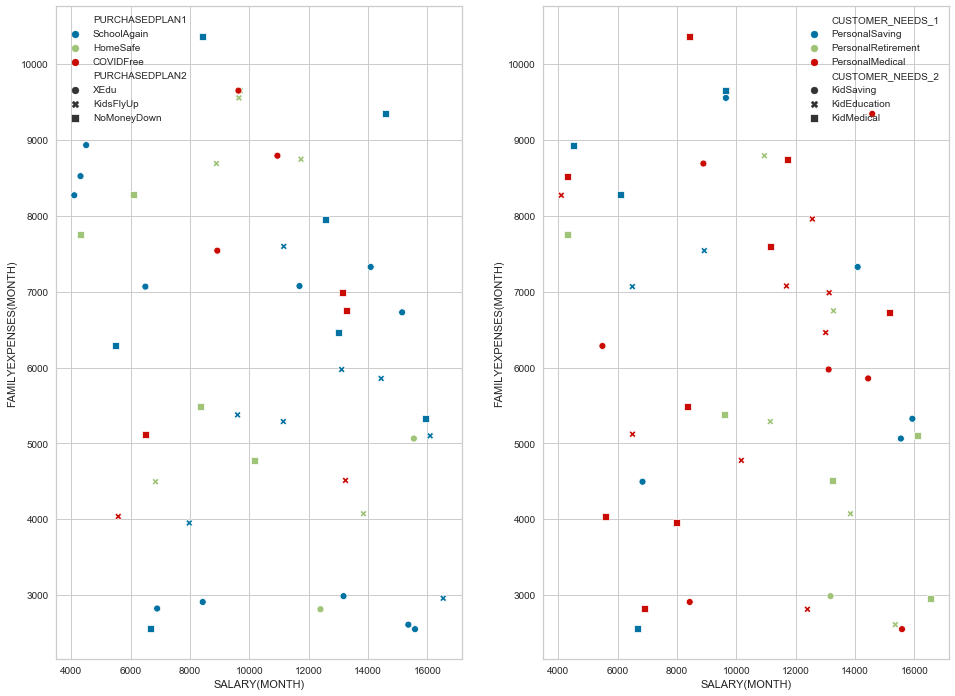

In [72]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(16,12))
sns.scatterplot(x="SALARY(MONTH)", y="FAMILYEXPENSES(MONTH)", hue="PURCHASEDPLAN1", style="PURCHASEDPLAN2", data=df3,ax=ax1)
sns.scatterplot(x="SALARY(MONTH)", y="FAMILYEXPENSES(MONTH)", hue="CUSTOMER_NEEDS_1", style="CUSTOMER_NEEDS_2", data=df3, ax=ax2)

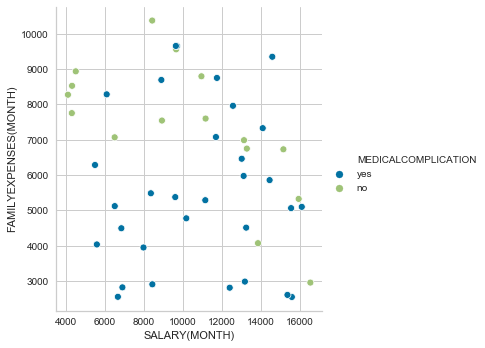

In [73]:
ax = sns.relplot(x="SALARY(MONTH)", y="FAMILYEXPENSES(MONTH)", hue="MEDICALCOMPLICATION", data=df3)

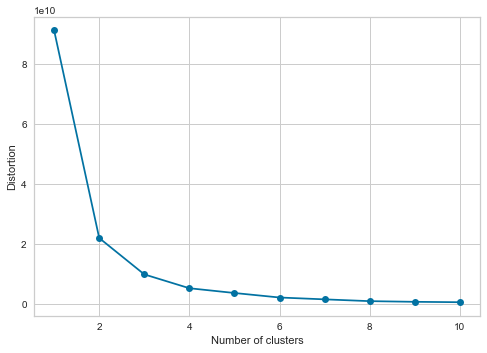

In [74]:
#To check which K is the best 
distortions = []
for i in range(1,11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()


In [75]:
km = KMeans(n_clusters=3, random_state=2)
km.fit(X)
df3_new = df3.copy()
df3_new = df3_new.drop(["PURCHASEDPLAN1","CUSTOMER_PURCHASED1","CUSTOMER_PURCHASED2"],axis=1)
df3_new['PURCHASEDPLAN1']=km.labels_
df3_new.head()

,AGE,GENDER,MARITALSTATUS,SMOKERSTATUS,LIFESTYLE,LANGUAGESPOKEN,HIGHESTEDUCATION,RACE,NATIONALITY,MALAYSIAPR,...,FAMILYEXPENSES(MONTH),ANNUALSALARY,CUSTOMER_NEEDS_1,CUSTOMER_NEEDS_2,TRANSPORT,PURCHASEDPLAN2,MEDICALCOMPLICATION,AGE_GROUP,SALARY(MONTH),PURCHASEDPLAN1
31,37.0,female,married,sometimes,pub_goer,malay,Master,malay,Malaysian,no,...,7325.0,169046.0,PersonalSaving,KidSaving,driving,XEdu,yes,"(30, 40]",14087.166667,1
34,25.0,male,married,frequent,home,english,Bachelor,malay,others,yes,...,5288.0,133717.0,PersonalRetirement,KidEducation,driving,KidsFlyUp,yes,"(20, 30]",11143.083333,2
35,44.0,male,single,sometimes,home,english,Bachelor,chinese,Malaysian,yes,...,2552.0,186967.0,PersonalMedical,KidSaving,driving,XEdu,yes,"(40, 50]",15580.583333,1
80,37.0,male,single,sometimes,outdoor,english,Bachelor,indian,others,yes,...,5325.0,191164.0,PersonalSaving,KidSaving,driving,NoMoneyDown,no,"(30, 40]",15930.333333,1
82,37.0,male,single,frequent,outdoor,malay,Diploma,malay,Malaysian,yes,...,9553.0,115770.0,PersonalSaving,KidSaving,driving,KidsFlyUp,no,"(30, 40]",9647.500000,2


In [76]:
km.labels_

array([1, 2, 1, 1, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 1, 2, 0, 2, 0, 0, 2, 1,
       2, 0, 1, 1, 1, 0, 2, 2, 1, 1, 1, 2, 0, 1, 2, 1, 2, 1, 1, 0, 2, 2,
       0, 0, 2])

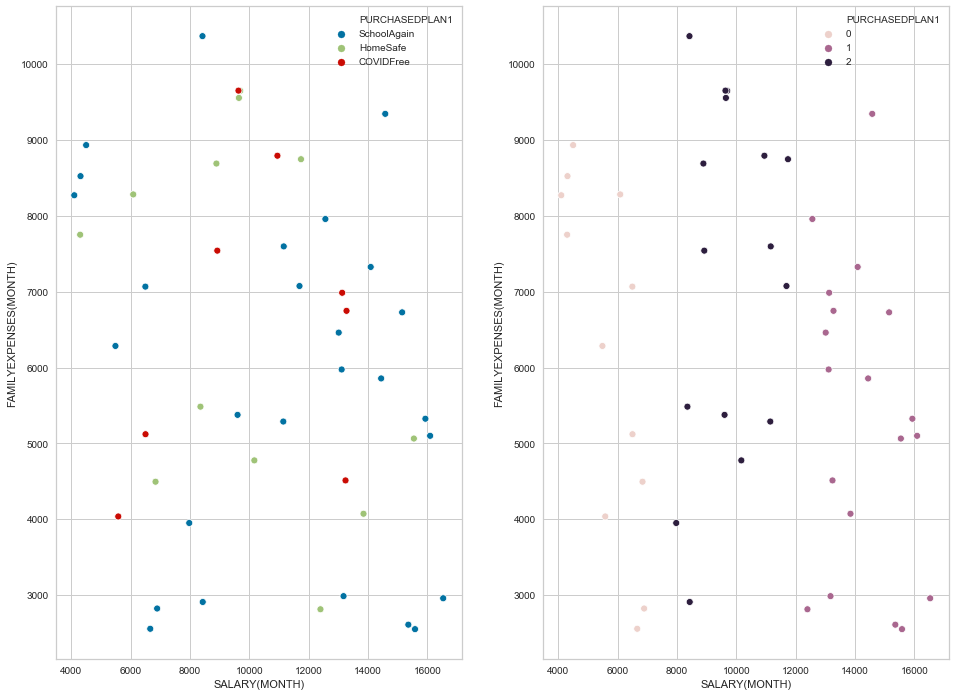

In [77]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(16,12))
sns.scatterplot(x="SALARY(MONTH)", y="FAMILYEXPENSES(MONTH)", hue="PURCHASEDPLAN1", data=df3,ax=ax1)
sns.scatterplot(x="SALARY(MONTH)", y="FAMILYEXPENSES(MONTH)", hue="PURCHASEDPLAN1", data=df3_new, ax=ax2)

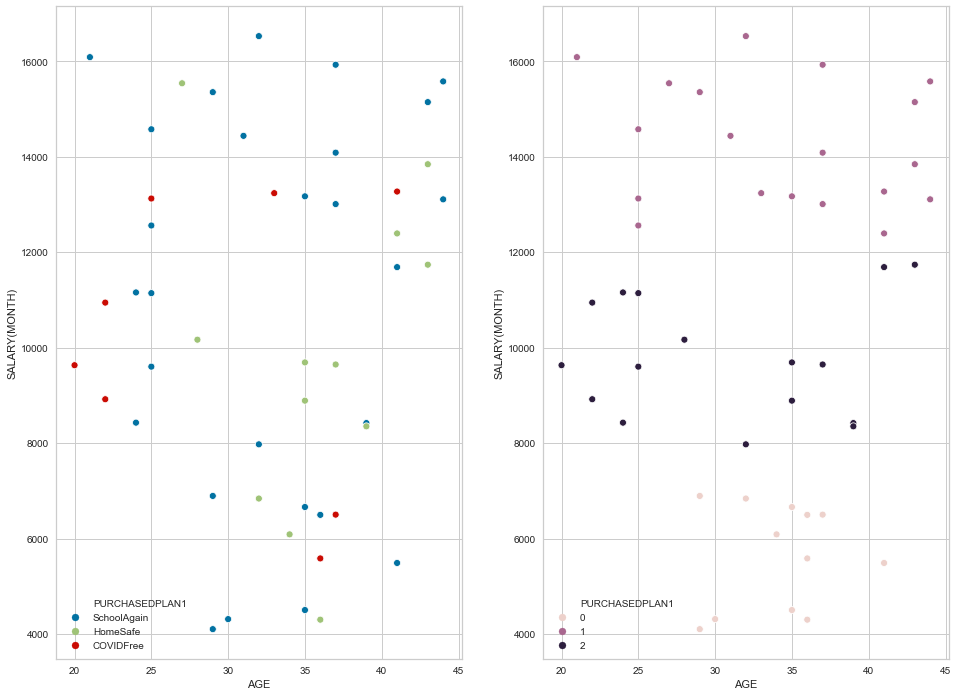

In [78]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(16,12))
sns.scatterplot(x="AGE", y="SALARY(MONTH)", hue="PURCHASEDPLAN1", data=df3,ax=ax1)
sns.scatterplot(x="AGE", y="SALARY(MONTH)", hue="PURCHASEDPLAN1", data=df3_new,ax=ax2)

0.5965359432896206


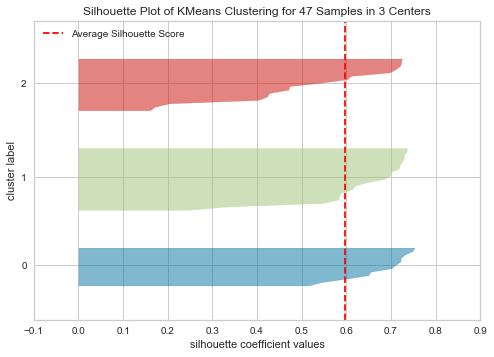

C:\Users\jiekl\anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001F1CB96ED48>,
                     colors='yellowbrick', model=None)

In [79]:
print(silhouette_score(X, km.labels_))
silhouette_visualizer(km,X,colors='yellowbrick')

In [80]:
#km.fit(X)
#df3_new_2 = df3.copy()
#df3_new_2 = df3_new_2.drop(["PURCHASEDPLAN2","CUSTOMER_PURCHASED1","CUSTOMER_PURCHASED2"],axis=1)
#df3_new_2['PURCHASEDPLAN2']=km.labels_
#df3_new_2.head()

In [81]:
#km.labels_

In [82]:
#fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(16,12))
#sns.scatterplot(x="SALARY(MONTH)", y="FAMILYEXPENSES(MONTH)", hue="PURCHASEDPLAN2", data=df3,ax=ax1)
#sns.scatterplot(x="SALARY(MONTH)", y="FAMILYEXPENSES(MONTH)", hue="PURCHASEDPLAN2", data=df3_new_2, ax=ax2)

In [83]:
#fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(16,12))
#sns.scatterplot(x="AGE", y="SALARY(MONTH)", hue="PURCHASEDPLAN2", data=df3,ax=ax1)
#sns.scatterplot(x="AGE", y="SALARY(MONTH)", hue="PURCHASEDPLAN2", data=df3_new_2,ax=ax2)

In [84]:
#print(silhouette_score(X, km.labels_))
#silhouette_visualizer(km,X,colors='yellowbrick')

### 3.4 Association Rules Mining 

#### 3.4.1 Customer_Needs_1 and PurchasePlan1

In [85]:
df_arm1 = df2[["CUSTOMER_NEEDS_1","PURCHASEDPLAN1"]]
dfv = df_arm1.values
te = TransactionEncoder()
te_ary = te.fit(dfv).transform(dfv)
df_arm = pd.DataFrame(te_ary, columns=te.columns_)
df_arm
frequent_itemsets = apriori(df_arm, min_support=0.05, use_colnames=True)
#print (frequent_itemsets)
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.2)
rules = rules.sort_values(['support', 'confidence'], ascending =[False, False])
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
13,(PersonalMedical),(SchoolAgain),0.396,0.588,0.234,0.590909,1.004947,0.001152,1.007111
12,(SchoolAgain),(PersonalMedical),0.588,0.396,0.234,0.397959,1.004947,0.001152,1.003254
15,(PersonalRetirement),(SchoolAgain),0.318,0.588,0.190,0.597484,1.016130,0.003016,1.023562
14,(SchoolAgain),(PersonalRetirement),0.588,0.318,0.190,0.323129,1.016130,0.003016,1.007578
17,(PersonalSaving),(SchoolAgain),0.286,0.588,0.164,0.573427,0.975215,-0.004168,0.965836


In [86]:
#To have a better views of the rules 
cnt = 0
itemsets = []
for index, rule in rules.iterrows():
    cnt += 1
    print("(Rule " + str(cnt) + ") " + list(rule['antecedents'])[0] + " -> " + list(rule['consequents'])[0])
    itemsets.append(list(rule['antecedents'])[0] + " -> " + list(rule['consequents'])[0])
    print("Support: " + str(round(rule['support'], 3)))
    print("Confidence: " + str(round(rule['confidence'], 3)))
    print("Lift: " + str(round(rule['lift'],3)))
    print("=====================================")

(Rule 1) PersonalMedical -> SchoolAgain
Support: 0.234
Confidence: 0.591
Lift: 1.005
(Rule 2) SchoolAgain -> PersonalMedical
Support: 0.234
Confidence: 0.398
Lift: 1.005
(Rule 3) PersonalRetirement -> SchoolAgain
Support: 0.19
Confidence: 0.597
Lift: 1.016
(Rule 4) SchoolAgain -> PersonalRetirement
Support: 0.19
Confidence: 0.323
Lift: 1.016
(Rule 5) PersonalSaving -> SchoolAgain
Support: 0.164
Confidence: 0.573
Lift: 0.975
(Rule 6) SchoolAgain -> PersonalSaving
Support: 0.164
Confidence: 0.279
Lift: 0.975
(Rule 7) COVIDFree -> PersonalMedical
Support: 0.092
Confidence: 0.418
Lift: 1.056
(Rule 8) PersonalMedical -> COVIDFree
Support: 0.092
Confidence: 0.232
Lift: 1.056
(Rule 9) HomeSafe -> PersonalMedical
Support: 0.07
Confidence: 0.365
Lift: 0.921
(Rule 10) HomeSafe -> PersonalRetirement
Support: 0.07
Confidence: 0.365
Lift: 1.146
(Rule 11) COVIDFree -> PersonalSaving
Support: 0.07
Confidence: 0.318
Lift: 1.113
(Rule 12) PersonalSaving -> COVIDFree
Support: 0.07
Confidence: 0.245
Lift

#### 3.4.2 Customer_Needs_2 and PurchasePlan2

In [87]:
df_arm2 = df2[["CUSTOMER_NEEDS_2","PURCHASEDPLAN2"]]
dfv2 = df_arm2.values
te_ary2 = te.fit(dfv2).transform(dfv2)
df_arm2 = pd.DataFrame(te_ary2, columns=te.columns_)
df_arm2
frequent_itemsets2 = apriori(df_arm2, min_support=0.05, use_colnames=True)
#print (frequent_itemsets2)
association_rules(frequent_itemsets2, metric="confidence", min_threshold=0.2)
rules2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=0.2)
rules2 = rules2.sort_values(['support', 'confidence'], ascending =[False, False]) 
rules2.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(XEdu),(KidEducation),0.378,0.434,0.162,0.428571,0.987492,-0.002052,0.990500
4,(KidEducation),(XEdu),0.434,0.378,0.162,0.373272,0.987492,-0.002052,0.992456
3,(NoMoneyDown),(KidEducation),0.308,0.434,0.146,0.474026,1.092226,0.012328,1.076099
2,(KidEducation),(NoMoneyDown),0.434,0.308,0.146,0.336406,1.092226,0.012328,1.042806
11,(XEdu),(KidMedical),0.378,0.388,0.142,0.375661,0.968199,-0.004664,0.980237


In [88]:
cnt =0
itemsets2 = []
for index, rule in rules2.iterrows():
    cnt += 1
    print("(Rule " + str(cnt) + ") " + list(rule['antecedents'])[0] + " -> " + list(rule['consequents'])[0])
    itemsets2.append(list(rule['antecedents'])[0] + " -> " + list(rule['consequents'])[0])
    print("Support: " + str(round(rule['support'], 3)))
    print("Confidence: " + str(round(rule['confidence'], 3)))
    print("Lift: " + str(round(rule['lift'],3)))
    print("=====================================")

(Rule 1) XEdu -> KidEducation
Support: 0.162
Confidence: 0.429
Lift: 0.987
(Rule 2) KidEducation -> XEdu
Support: 0.162
Confidence: 0.373
Lift: 0.987
(Rule 3) NoMoneyDown -> KidEducation
Support: 0.146
Confidence: 0.474
Lift: 1.092
(Rule 4) KidEducation -> NoMoneyDown
Support: 0.146
Confidence: 0.336
Lift: 1.092
(Rule 5) XEdu -> KidMedical
Support: 0.142
Confidence: 0.376
Lift: 0.968
(Rule 6) KidMedical -> XEdu
Support: 0.142
Confidence: 0.366
Lift: 0.968
(Rule 7) KidsFlyUp -> KidMedical
Support: 0.132
Confidence: 0.42
Lift: 1.083
(Rule 8) KidMedical -> KidsFlyUp
Support: 0.132
Confidence: 0.34
Lift: 1.083
(Rule 9) KidsFlyUp -> KidEducation
Support: 0.126
Confidence: 0.401
Lift: 0.925
(Rule 10) KidEducation -> KidsFlyUp
Support: 0.126
Confidence: 0.29
Lift: 0.925
(Rule 11) NoMoneyDown -> KidMedical
Support: 0.114
Confidence: 0.37
Lift: 0.954
(Rule 12) KidMedical -> NoMoneyDown
Support: 0.114
Confidence: 0.294
Lift: 0.954
(Rule 13) KidSaving -> XEdu
Support: 0.074
Confidence: 0.416
Lift

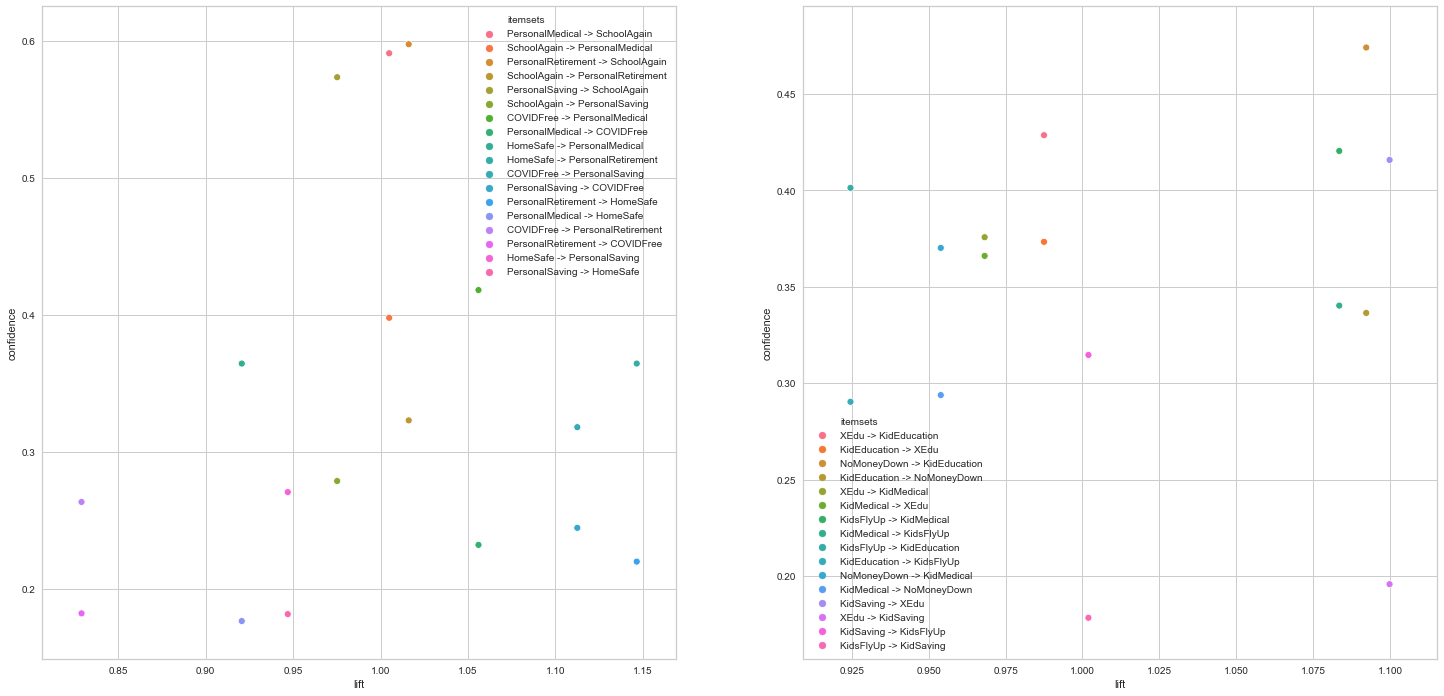

In [89]:
rules['itemsets'] = itemsets
rules2['itemsets'] = itemsets2
#fig, axs = plt.subplots(2, 1, figsize=(13,10))
#axs[0].plot(rules['lift'], rules['confidence'], 'yo', rules['lift'], fit_fn1(rules['lift']))
#axs[0].set_title('Customer_Needs_1 and PurchasePlan1')
#axs[1].plot(rules2['lift'], rules2['confidence'], 'yo', rules2['lift'],fit_fn2(rules2['lift']))
#axs[1].set_title('Customer_Needs_2 and PurchasePlan2')
#axs[1, 0].plot(rules3['lift'], rules3['confidence'], 'yo', rules3['lift'], fit_fn3(rules3['lift']))
#axs[1, 0].set_title('PurchasePlan1 and PurchasePlan2')
#axs[1, 1].plot(rules4['lift'], rules4['confidence'], 'yo', rules4['lift'], fit_fn4(rules4['lift']))
#axs[1, 1].set_title('Customer_Needs_1 and Customer_Needs_2')
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(25,12))
sns.scatterplot(x="lift", y="confidence", hue="itemsets", data=rules,ax=ax1)
sns.scatterplot(x="lift", y="confidence", hue="itemsets", data=rules2,ax=ax2)

### 4.0 Results and Discussion / Findings

#### ALL THE RESULTS HAS BEEN PLACED IN THE REPORT 

### 5.0 Reference
http://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/

https://stackabuse.com/association-rule-mining-via-apriori-algorithm-in-python/

https://medium.com/analytics-vidhya/association-analysis-in-python-2b955d0180c

https://intelligentonlinetools.com/blog/2018/02/10/how-to-create-data-visualization-for-association-rules-in-data-mining/

https://www.tutorialspoint.com/data_mining/dm_cluster_analysis.htm

https://searchbusinessanalytics.techtarget.com/definition/association-rules-in-data-mining